In [3243]:
# 导入必要的库
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from scipy import stats
from pandas_datareader import data as pdr
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay


## Data

In [3246]:
df = pd.read_csv('combined_data.csv')

In [3248]:
df.tail(40)

,Date,Close,High,Low,Open,Volume,Log_Returns,GDP,GDPNow,PMI,sentiment_score,treasury_difference_10_2,credit_spread,Gold_Log_Returns,VIX
8524,2023-11-02,4317.779785,4319.720215,4268.259766,4268.259766,4669780000,0.018683,27967.697,28937.748608,46.7,58.0,-0.38,12.986092,0.780251,15.66
8525,2023-11-03,4358.339844,4373.620117,4334.229980,4334.229980,4570960000,0.009350,27967.697,28937.748608,46.7,58.0,-0.38,12.898727,0.786170,14.91
8526,2023-11-06,4365.979980,4372.209961,4347.529785,4364.270020,3656340000,0.001751,27967.697,28937.748608,46.7,58.0,-0.38,13.193359,0.784955,14.89
8527,2023-11-07,4378.379883,4386.259766,4355.410156,4366.209961,3791230000,0.002836,27967.697,28937.748608,46.7,58.0,-0.38,12.746712,0.792774,14.81
8528,2023-11-08,4382.779785,4391.200195,4359.759766,4384.370117,3729510000,0.001004,27967.697,28937.748608,46.7,58.0,-0.38,11.821556,0.801275,14.45
8529,2023-11-09,4347.350098,4393.399902,4343.939941,4391.410156,3900780000,-0.008117,27967.697,28937.748608,46.7,58.0,-0.38,12.787086,0.800968,15.29
8530,2023-11-10,4415.240234,4418.029785,4353.339844,4364.149902,3665080000,0.015496,27967.697,28937.748608,46.7,58.0,-0.38,12.803207,0.809977,14.17
8531,2023-11-13,4411.549805,4421.759766,4393.819824,4406.660156,3326240000,-0.000836,27967.697,28937.748608,46.7,58.0,-0.38,13.000824,0.825360,14.76
8532,2023-11-14,4495.700195,4508.669922,4458.970215,4458.970215,4700350000,0.018895,27967.697,28937.748608,46.7,58.0,-0.38,12.625237,0.837602,14.16
8533,2023-11-15,4502.879883,4521.169922,4495.310059,4505.299805,4347170000,0.001596,27967.697,28937.748608,46.7,58.0,-0.38,13.305763,0.830855,14.18


In [3250]:
df['Date'] = pd.to_datetime(df['Date'])       # 确保 Date 是 datetime 类型

In [3252]:
returns = df['Log_Returns'].dropna().values

## Stage 1

In [3255]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3257]:
def kim_smoother(xi_filter, xi_pred, P):
    """
    Smooth the filter probabilities using Kim's smoother.
    """
    T, n_states = xi_filter.shape
    xi_smooth = np.zeros_like(xi_filter)
    xi_smooth[-1, :] = xi_filter[-1, :]
    
    for t in range(T - 2, -1, -1):
        ratio = np.zeros(n_states)
        for i in range(n_states):
            ratio[i] = np.sum(P[i, :] * (xi_smooth[t+1, :] / (xi_pred[t+1, :] + 1e-12)))
        xi_smooth[t, :] = xi_filter[t, :] * ratio
        xi_smooth[t, :] /= np.sum(xi_smooth[t, :])
    return xi_smooth


In [3259]:
def forward_filter_tmstgarch_pq(returns, params, p, q):
    T = len(returns)
    n_states = 3
    # mu, omega, alpha, beta, gamma for each state
    mu      = [params[f'mu{i+1}']      for i in range(n_states)]
    omega   = [params[f'omega{i+1}']   for i in range(n_states)]
    alpha   = [params[f'alpha{i+1}']   for i in range(n_states)]
    beta    = [params[f'beta{i+1}']    for i in range(n_states)]
    gamma   = [params[f'gamma{i+1}']   for i in range(n_states)]
    P_flat  = params['transition_probs']
    P       = np.array(P_flat).reshape(n_states, n_states)
    zeta    = params['initial_probs']

    # allocate
    xi_filt   = np.zeros((T, n_states))
    xi_pred   = np.zeros((T, n_states))
    likelihood= np.zeros(T)
    # ℎ-history for ε² and σ²
    e2_hist = np.zeros((T, n_states))
    s2_hist = np.zeros((T, n_states))

    # init
    xi_filt[0] = zeta
    xi_pred[0] = zeta
    # start var at unconditional var
    init_var = np.var(returns)
    s2_hist[:] = init_var

    for t in range(1, T):
        r_t = returns[t]
        # first compute σ² for each state
        for i in range(n_states):
            # collect past q residual squares
            arch = 0.0
            for j in range(1, q+1):
                e = returns[t-j] - mu[i]
                arch += alpha[i]*e*e + gamma[i]*e*e*(e<0)
            # collect past p σ²
            garch = np.sum([beta[i]*s2_hist[t-j, i] for j in range(1, p+1)])
            s2_hist[t, i] = omega[i] + arch + garch

        # predict xi
        xi_pred[t] = xi_filt[t-1] @ P

        # likelihood components
        f = np.zeros(n_states)
        for i in range(n_states):
            var = s2_hist[t, i] + 1e-12
            f[i] = (1.0/np.sqrt(2*np.pi*var)) * np.exp(-0.5*(r_t-mu[i])**2/var)

        mix = np.dot(xi_pred[t], f)
        likelihood[t] = mix
        xi_filt[t] = xi_pred[t] * f / (mix + 1e-12)

    return xi_filt, xi_pred, likelihood, s2_hist


In [3261]:
import numpy as np
import pandas as pd

# --- 0) 准备 DataFrame ---
# 假设你的日度 DataFrame 名为 df，包含 'date' 和 'returns' 列

# --- 1) 初始参数 ---
initial_params = {
    'mu1': 0.0, 'omega1': 1e-5, 'alpha1': 0.05, 'beta1': 0.9, 'gamma1': 0.05,
    'mu2': 0.0, 'omega2': 1e-5, 'alpha2': 0.07, 'beta2': 0.85, 'gamma2': 0.05,
    'mu3': 0.0, 'omega3': 1e-5, 'alpha3': 0.1,  'beta3': 0.8,  'gamma3': 0.05,
    'transition_probs': [0.9,0.05,0.05,
                         0.05,0.9,0.05,
                         0.05,0.05,0.9],
    'initial_probs':    [1/3,1/3,1/3]
}

# --- 2) 前向滤波 & 平滑 ---
xi_f, xi_p, ll, s2 = forward_filter_tmstgarch_pq(
    returns=df['Log_Returns'].values,   # ← 注意这里 .values
    params=initial_params,
    p=1, q=2
)

P_mat = np.array(initial_params['transition_probs']).reshape(3,3)
xi_s  = kim_smoother(xi_f, xi_p, P_mat)   # xi_s.shape == (T, 3)

# --- 3) 最可能的状态索引 ---
state_idx = np.argmax(xi_s, axis=1)       # 每个时点的状态：0,1,2

# --- 4) 根据各状态平均方差确定 Low/Mid/High 的映射 ---
mean_var = s2.mean(axis=0)                # array([var_state0, var_state1, var_state2])
order    = np.argsort(mean_var)           # 例如 [1,0,2]
label_map = {
    int(order[0]): 'Low',
    int(order[1]): 'Mid',
    int(order[2]): 'High'
}

# --- 5) 构造带标签与概率的 DataFrame ---
df_states = pd.DataFrame({
    'VolState':  [label_map[s] for s in state_idx],
    'Prob_Low':  xi_s[:, order[0]],
    'Prob_Mid':  xi_s[:, order[1]],
    'Prob_High': xi_s[:, order[2]],
}, index=df.index)

print(df_states.head())


  VolState  Prob_Low  Prob_Mid  Prob_High
0      Low  0.341139  0.338161   0.320700
1      Low  0.342517  0.339013   0.318470
2      Low  0.343071  0.340011   0.316918
3      Low  0.342994  0.341092   0.315915
4      Mid  0.340013  0.342042   0.317945


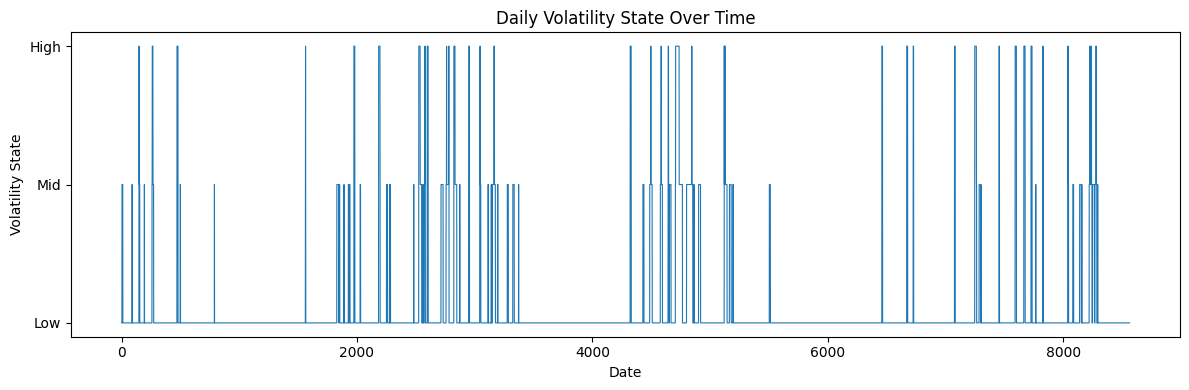

In [3263]:
import matplotlib.pyplot as plt

# 假设 df_states 已经包含了以下列，并且以日期为索引：
#   'VolState'    （值为 'Low','Mid','High'）
#   索引为 pd.DatetimeIndex

# 1) 定义映射
state_map = {'Low': 0, 'Mid': 1, 'High': 2}

# 2) 映射为数值序列
state_codes = df_states['VolState'].map(state_map)

# 3) 绘图
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_states.index, state_codes, lw=0.8)
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['Low', 'Mid', 'High'])
ax.set_xlabel('Date')
ax.set_ylabel('Volatility State')
ax.set_title('Daily Volatility State Over Time')
plt.tight_layout()
plt.show()


In [3265]:
df = df.join(df_states, how='left')

In [3267]:
# 1) ensure it’s datetime
df['Date'] = pd.to_datetime(df['Date'])

# 2) set it as the index
df.set_index('Date', inplace=True)


In [3269]:
df

,Close,High,Low,Open,Volume,Log_Returns,GDP,GDPNow,PMI,sentiment_score,treasury_difference_10_2,credit_spread,Gold_Log_Returns,VIX,VolState,Prob_Low,Prob_Mid,Prob_High
Date,,,,,,,,,,,,,,,,,,
1990-01-03,358.760010,360.589996,357.890015,359.690002,192330000,-0.002589,NaN,NaN,47.4,NaN,0.12,NaN,NaN,18.190001,Low,0.341139,0.338161,0.320700
1990-01-04,355.670013,358.760010,352.890015,358.760010,177000000,-0.008650,NaN,NaN,47.4,NaN,0.12,NaN,NaN,19.219999,Low,0.342517,0.339013,0.318470
1990-01-05,352.200012,355.670013,351.350006,355.670013,158530000,-0.009804,NaN,NaN,47.4,NaN,0.12,NaN,NaN,20.110001,Low,0.343071,0.340011,0.316918
1990-01-08,353.790009,354.239990,350.540009,352.200012,140110000,0.004504,NaN,NaN,47.4,NaN,0.12,NaN,NaN,20.260000,Low,0.342994,0.341092,0.315915
1990-01-09,349.619995,354.170013,349.609985,353.829987,155210000,-0.011857,NaN,NaN,47.4,NaN,0.12,NaN,NaN,22.200001,Mid,0.340013,0.342042,0.317945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,4754.629883,4772.939941,4736.770020,4753.919922,3046770000,0.001659,27967.697,28937.748608,46.7,58.0,-0.44,10.514542,0.846610,13.030000,Low,0.485259,0.340049,0.174693
2023-12-26,4774.750000,4784.720215,4758.450195,4758.859863,2513910000,0.004223,27967.697,28937.748608,46.7,58.0,-0.44,10.466141,0.842044,12.990000,Low,0.484475,0.341178,0.174347
2023-12-27,4781.580078,4785.390137,4768.899902,4773.450195,2748450000,0.001429,27967.697,28937.748608,46.7,58.0,-0.44,9.779533,0.842939,12.430000,Low,0.482738,0.341356,0.175906


In [3271]:
mapping = {'Low': 0, 'Mid': 1, 'High': 2}
df['VolState'] = df['VolState'].map(mapping).astype(int)

In [3273]:
df

,Close,High,Low,Open,Volume,Log_Returns,GDP,GDPNow,PMI,sentiment_score,treasury_difference_10_2,credit_spread,Gold_Log_Returns,VIX,VolState,Prob_Low,Prob_Mid,Prob_High
Date,,,,,,,,,,,,,,,,,,
1990-01-03,358.760010,360.589996,357.890015,359.690002,192330000,-0.002589,NaN,NaN,47.4,NaN,0.12,NaN,NaN,18.190001,0,0.341139,0.338161,0.320700
1990-01-04,355.670013,358.760010,352.890015,358.760010,177000000,-0.008650,NaN,NaN,47.4,NaN,0.12,NaN,NaN,19.219999,0,0.342517,0.339013,0.318470
1990-01-05,352.200012,355.670013,351.350006,355.670013,158530000,-0.009804,NaN,NaN,47.4,NaN,0.12,NaN,NaN,20.110001,0,0.343071,0.340011,0.316918
1990-01-08,353.790009,354.239990,350.540009,352.200012,140110000,0.004504,NaN,NaN,47.4,NaN,0.12,NaN,NaN,20.260000,0,0.342994,0.341092,0.315915
1990-01-09,349.619995,354.170013,349.609985,353.829987,155210000,-0.011857,NaN,NaN,47.4,NaN,0.12,NaN,NaN,22.200001,1,0.340013,0.342042,0.317945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,4754.629883,4772.939941,4736.770020,4753.919922,3046770000,0.001659,27967.697,28937.748608,46.7,58.0,-0.44,10.514542,0.846610,13.030000,0,0.485259,0.340049,0.174693
2023-12-26,4774.750000,4784.720215,4758.450195,4758.859863,2513910000,0.004223,27967.697,28937.748608,46.7,58.0,-0.44,10.466141,0.842044,12.990000,0,0.484475,0.341178,0.174347
2023-12-27,4781.580078,4785.390137,4768.899902,4773.450195,2748450000,0.001429,27967.697,28937.748608,46.7,58.0,-0.44,9.779533,0.842939,12.430000,0,0.482738,0.341356,0.175906


In [3275]:
# —— 1) 先填充 sentiment_score 到日度 —— 
df['sentiment_score'] = df['sentiment_score'].resample('D').ffill()

# 1) 取每个季度末的 GDP 水平
gdp_q = df['GDP'].resample('Q').last()

# 2) 手动在 1990‑12‑31 插入基准值 6004.733
baseline = pd.Series({pd.Timestamp('1990-12-31'): 6004.733})
gdp_q    = pd.concat([baseline, gdp_q]).sort_index()

# 3) 计算季度对数增长率（diff 后不会有 NaN，第一个基于基准计算）
gdp_growth_q = np.log(gdp_q).diff().dropna()


In [3277]:
# GDP 是季度的，要先变成 daily 后再 forward fill
df['GDP'] = df['GDP'].resample('D').ffill()
df['GDPNow'] = df['GDPNow'].resample('D').ffill()
df['sentiment_score'] = df['sentiment_score'].resample('D').ffill()

In [3279]:
df = df.loc['1991':]
df

,Close,High,Low,Open,Volume,Log_Returns,GDP,GDPNow,PMI,sentiment_score,treasury_difference_10_2,credit_spread,Gold_Log_Returns,VIX,VolState,Prob_Low,Prob_Mid,Prob_High
Date,,,,,,,,,,,,,,,,,,
1991-01-02,326.450012,330.750000,326.450012,330.200012,126280000,-0.011482,6015.116,NaN,40.8,NaN,0.96,NaN,NaN,26.620001,0,0.467802,0.346128,0.186070
1991-01-03,321.910004,326.529999,321.899994,326.459991,141450000,-0.014005,6015.116,NaN,40.8,NaN,0.96,NaN,NaN,27.930000,0,0.442104,0.349219,0.208677
1991-01-04,321.000000,322.350006,318.869995,321.910004,140820000,-0.002831,6015.116,NaN,40.8,NaN,0.96,NaN,NaN,27.190001,0,0.426832,0.351953,0.221215
1991-01-07,315.440002,320.970001,315.440002,320.970001,130610000,-0.017473,6015.116,NaN,40.8,NaN,0.96,NaN,NaN,28.950001,0,0.407257,0.352953,0.239790
1991-01-08,314.899994,316.970001,313.790009,315.440002,143390000,-0.001713,6015.116,NaN,40.8,NaN,0.96,NaN,NaN,30.379999,0,0.394709,0.355739,0.249552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,4754.629883,4772.939941,4736.770020,4753.919922,3046770000,0.001659,27967.697,28937.748608,46.7,58.0,-0.44,10.514542,0.846610,13.030000,0,0.485259,0.340049,0.174693
2023-12-26,4774.750000,4784.720215,4758.450195,4758.859863,2513910000,0.004223,27967.697,28937.748608,46.7,58.0,-0.44,10.466141,0.842044,12.990000,0,0.484475,0.341178,0.174347
2023-12-27,4781.580078,4785.390137,4768.899902,4773.450195,2748450000,0.001429,27967.697,28937.748608,46.7,58.0,-0.44,9.779533,0.842939,12.430000,0,0.482738,0.341356,0.175906


In [3281]:
# 月度聚合
monthly_logr   = df['Log_Returns'].resample('M').sum()
monthly_ret    = np.exp(monthly_logr) - 1
monthly_df = df.resample('M').agg({
    'VolState':        lambda x: x.mode().iloc[0],
    'GDP':             'last',
    'PMI':             'last',
    'sentiment_score': 'last',
    'VIX':             'last',
    'GDPNow':          'last',
    'treasury_difference_10_2': 'last',
    'credit_spread':    'last',
    'Gold_Log_Returns':    'last'
})

monthly_df['MarketReturn'] = monthly_ret
monthly_df.dropna(subset=['MarketReturn'], inplace=True)
print(monthly_df.head())

            VolState       GDP   PMI  sentiment_score        VIX  GDPNow  \
Date                                                                       
1991-01-31         0  6015.116  40.8              NaN  20.910000     NaN   
1991-02-28         0  6004.733  39.2              NaN  21.230000     NaN   
1991-03-31         0  6004.733  39.4              NaN  16.879999     NaN   
1991-04-30         0  6004.733  40.7              NaN  18.240000     NaN   
1991-05-31         0  6035.178  42.8              NaN  15.930000     NaN   

            treasury_difference_10_2  credit_spread  Gold_Log_Returns  \
Date                                                                    
1991-01-31                      0.96            NaN               NaN   
1991-02-28                      0.98            NaN               NaN   
1991-03-31                      1.01            NaN               NaN   
1991-04-30                      1.09            NaN               NaN   
1991-05-31                   

## Stage 2

In [3284]:
df['MarketReturn'] = df['Log_Returns']


# Daily

Model is not converging.  Current: 49.95741833387195 is not greater than 60.83853855087347. Delta is -10.881120217001524
Model is not converging.  Current: 9966.059759829795 is not greater than 9966.05999998276. Delta is -0.00024015296366997063


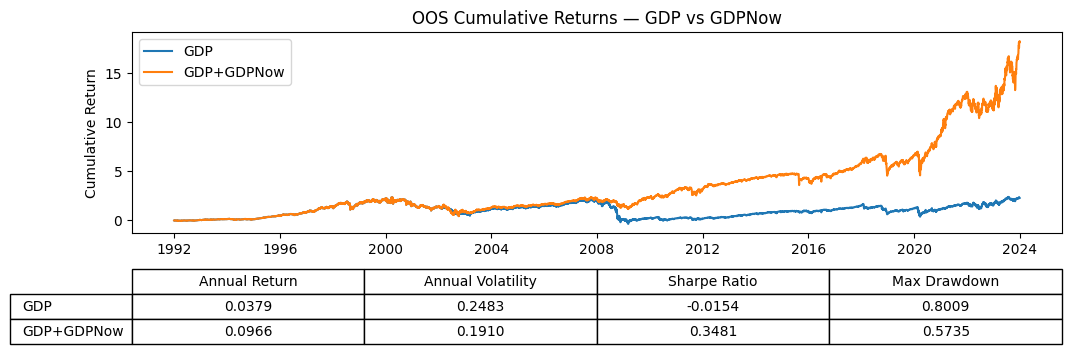

In [3293]:
import warnings
warnings.filterwarnings("ignore", message="Model is not converging")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from hmmlearn.hmm import GaussianHMM
import ruptures as rpt    # 用于结构性破裂检测
import matplotlib.gridspec as gridspec

# ──────────────────────────────────────────────────────────────────
# 假定 df 已经加载，并且包含 Daily 索引和列：
#   'MarketReturn', 'VolState', 'GDP', 'GDPNow'
# ──────────────────────────────────────────────────────────────────
df = df.loc[:'2023-12-31']
df['GDP']     = df['GDP'].fillna(method='ffill')
first_gdpnow_date = df['GDPNow'].first_valid_index()
first_gdpnow_pos  = df.index.get_loc(first_gdpnow_date)

# ─── 1. 生成两套滞后：GDP 用 4 个月，GDPNow 用 1 个月 ───
df['GDP_lag120']    = df['GDP'].shift(120)   # 上一季度（约 120 个 trading days）
df['GDPNow_lag30']  = df['GDPNow'].shift(30) # 上个月（约 30 个 trading days）

# ──────────────────────────────────────────────────────────────────
# 工具函数
# ──────────────────────────────────────────────────────────────────
def sharpe_ratio(log_returns, freq=12, rf=0.01):
    total_log  = np.sum(log_returns)
    annual_log = total_log * (freq / len(log_returns))
    annual_rtn = np.exp(annual_log) - 1
    vol_annual = np.std(log_returns, ddof=0) * np.sqrt(freq)
    return (annual_rtn - rf) / vol_annual

def max_drawdown(equity: pd.Series):
    dd = equity / equity.cummax() - 1
    return dd.min()

def annual_return(log_rets, freq):
    tot = log_rets.sum()
    return np.exp(tot * (freq / len(log_rets))) - 1

n_components = 3
freq = 252  # 日度频率。若改为月度请设为 12

# ──────────────────────────────────────────────────────────────────
# 2. 扩张窗口 + 按年滚动测试 — GDP+GDPNow 动态特征
# ──────────────────────────────────────────────────────────────────
strategy_oos = []
metrics      = []
state_oos    = []
freq_history = []
exposures    = None
final_map    = None

for yr in range(1992, 2024):
    train_idx = df.index[df.index.year < yr]
    test_idx  = df.index[df.index.year == yr]
    if len(train_idx) < n_components or len(test_idx) == 0:
        continue

    # 动态选择滞后特征
    last_loc = df.index.get_loc(train_idx[-1])
    if last_loc > first_gdpnow_pos + 1:
        feats = ['VolState', 'GDPNow_lag30']
    else:
        feats = ['VolState', 'GDP_lag120']

    # 构造训练/测试集
    X_tr_df = df[feats].loc[train_idx].dropna()
    y_tr_df = df.loc[X_tr_df.index, 'MarketReturn']
    X_te_df = df[feats].loc[test_idx].dropna()
    y_te_df = df.loc[X_te_df.index, 'MarketReturn']

    X_tr, y_tr = X_tr_df.values, y_tr_df.values
    X_te, y_te = X_te_df.values, y_te_df.values

    # 标准化
    scaler = StandardScaler().fit(X_tr)
    X_tr_s = scaler.transform(X_tr)
    X_te_s = scaler.transform(X_te)

    # 拟合 HMM
    model = GaussianHMM(n_components=n_components,
                        covariance_type='diag',
                        n_iter=200, tol=1e-2, random_state=0)
    model.min_covar = 1e-3
    model.fit(X_tr_s)

    # 状态频率 & 结构性破裂检测（决定是否重训练 exposures）
    states_tr = model.predict(X_tr_s)
    freq_history.append(np.bincount(states_tr, minlength=n_components) / len(states_tr))
    retrain = False
    if len(freq_history) >= 10:
        bkps = rpt.Pelt(model="rbf") \
                  .fit(np.array(freq_history)[:, 0].reshape(-1, 1)) \
                  .predict(pen=1.0)
        retrain = (bkps and bkps[-1] == len(freq_history))

    # 校准 exposures（第一次或破裂时）
    if exposures is None or retrain:
        stats = []
        for s in range(n_components):
            mask = (states_tr == s)
            if mask.sum() > 0:
                r      = y_tr[mask]
                mu     = r.mean()
                mad    = np.abs(r - mu).mean()
                vol    = r.std()
                sharpe = mu / vol if vol > 0 else np.nan
            else:
                mu = mad = vol = sharpe = np.nan
            stats.append({'state': s, 'mean': mu, 'mad': mad, 'vol': vol, 'sharpe': sharpe})
        df_stats         = pd.DataFrame(stats).set_index('state')
        df_stats['score'] = (df_stats['sharpe'] + df_stats['mean']/df_stats['mad']) / 2
        order            = df_stats['score'].sort_values().index.tolist()
        bear, side, bull = order
        exposures        = np.array([0.5, 1.0, 2.0])[np.argsort(order)]
        final_map        = (bear, side, bull)

    # OOS 隐状态 & 策略收益
    states_te = model.predict(X_te_s)
    state_oos.append(pd.Series(states_te, index=X_te_df.index))
    strat_ret = exposures[states_te] * y_te
    strategy_oos.append(pd.Series(strat_ret, index=X_te_df.index))

    # 性能指标（可选保存或打印）
    mse  = mean_squared_error(y_te, strat_ret)
    mae  = mean_absolute_error(y_te, strat_ret)
    rmse = np.sqrt(mse)
    denom= np.clip(strat_ret**2, 1e-6, None)
    qlike= np.mean((y_te**2)/denom - np.log((y_te**2)/denom) - 1)
    sr   = sharpe_ratio(np.log1p(strat_ret), freq=freq)
    eq   = (1 + pd.Series(strat_ret, index=X_te_df.index)).cumprod()
    mdd  = max_drawdown(eq)

    metrics.append({
        'year': yr, 'MSE': mse, 'MAE': mae,
        'RMSE': rmse, 'QLIKE': qlike,
        'Sharpe': sr, 'MaxDD': mdd
    })

# ──────────────────────────────────────────────────────────────────
# 3. 扩张窗口 + 按年滚动测试 — GDP 仅用 4 个月滞后
# ──────────────────────────────────────────────────────────────────
strategy_oos_gdp = []
exposures_gdp    = None
for yr in range(1992, 2024):
    train_idx = df.index[df.index.year < yr]
    test_idx  = df.index[df.index.year == yr]
    if len(train_idx) < n_components or len(test_idx) == 0:
        continue

    # 强制 GDP-only
    feats = ['VolState', 'GDP_lag120']

    # 构造训练/测试集
    X_tr_df = df[feats].loc[train_idx].dropna()
    y_tr_df = df.loc[X_tr_df.index, 'MarketReturn']
    X_te_df = df[feats].loc[test_idx].dropna()
    y_te_df = df.loc[X_te_df.index, 'MarketReturn']

    X_tr, y_tr = X_tr_df.values, y_tr_df.values
    X_te, y_te = X_te_df.values, y_te_df.values

    # 标准化
    scaler   = StandardScaler().fit(X_tr)
    X_tr_s   = scaler.transform(X_tr)
    X_te_s   = scaler.transform(X_te)

    # 拟合 HMM
    model    = GaussianHMM(n_components=n_components,
                           covariance_type='diag',
                           n_iter=200, tol=1e-2, random_state=0)
    model.min_covar = 1e-3
    model.fit(X_tr_s)

    # 校准 exposures_gdp（第一次）
    if exposures_gdp is None:
        states_tr = model.predict(X_tr_s)
        stats = []
        for s in range(n_components):
            mask = (states_tr == s)
            if mask.sum() > 0:
                r      = y_tr[mask]
                mu     = r.mean()
                mad    = np.abs(r - mu).mean()
                vol    = r.std()
                sharpe = mu / vol if vol > 0 else np.nan
            else:
                mu = mad = vol = sharpe = np.nan
            stats.append({'state': s, 'mean': mu, 'mad': mad, 'vol': vol, 'sharpe': sharpe})
        df_stats         = pd.DataFrame(stats).set_index('state')
        df_stats['score']= (df_stats['sharpe'] + df_stats['mean']/df_stats['mad']) / 2
        order            = df_stats['score'].sort_values().index.tolist()
        bear, side, bull = order
        exposures_gdp    = np.array([0.5,1.0,2.0])[np.argsort(order)]

    # OOS 收益
    states_te = model.predict(X_te_s)
    strat_ret = exposures_gdp[states_te] * y_te
    strategy_oos_gdp.append(pd.Series(strat_ret, index=X_te_df.index))

# ──────────────────────────────────────────────────────────────────
# 4. 绘图 & 对比：GDP vs GDP+GDPNow
# ──────────────────────────────────────────────────────────────────
# 合并并对齐
strat_log_comb = pd.concat(strategy_oos).sort_index()
strat_log_gdp  = pd.concat(strategy_oos_gdp).sort_index()
start         = max(strat_log_comb.index.min(), strat_log_gdp.index.min())

series = {
    'GDP':        strat_log_gdp.loc[start:],
    'GDP+GDPNow': strat_log_comb.loc[start:]
}

# 计算性能指标
perf = {}
for name, logs in series.items():
    ann_ret = annual_return(logs, freq)
    ann_vol = np.std(logs, ddof=0) * np.sqrt(freq)
    sr      = sharpe_ratio(np.log1p(logs), freq=freq)
    eq      = np.exp(logs.cumsum())
    mdd     = max_drawdown(eq)
    perf[name] = [ann_ret, ann_vol, sr, abs(mdd)]

row_labels = list(perf.keys())
col_labels = ['Annual Return','Annual Volatility','Sharpe Ratio','Max Drawdown']
cell_text  = [[f"{v:.4f}" for v in perf[r]] for r in row_labels]

# 绘图
fig = plt.figure(figsize=(12, 4))
gs  = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.3)

ax0 = fig.add_subplot(gs[0])
for name, logs in series.items():
    cum = np.exp(logs.cumsum()) - 1
    ax0.plot(cum, label=name)
ax0.set_ylabel('Cumulative Return')
ax0.set_title('OOS Cumulative Returns — GDP vs GDPNow')
ax0.legend(loc='upper left')

ax1 = fig.add_subplot(gs[1])
ax1.axis('off')
tbl = ax1.table(
    cellText=cell_text,
    rowLabels=row_labels,
    colLabels=col_labels,
    cellLoc='center',
    loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

plt.tight_layout()
plt.show()


Model is not converging.  Current: 49.95741833387195 is not greater than 60.83853855087347. Delta is -10.881120217001524
Model is not converging.  Current: 9966.059759830006 is not greater than 9966.059999982966. Delta is -0.00024015296003199182


最终映射 → bear=2, side=1, bull=0
OOS 隐状态预测次数： {0: 7074, 1: 674, 2: 311}


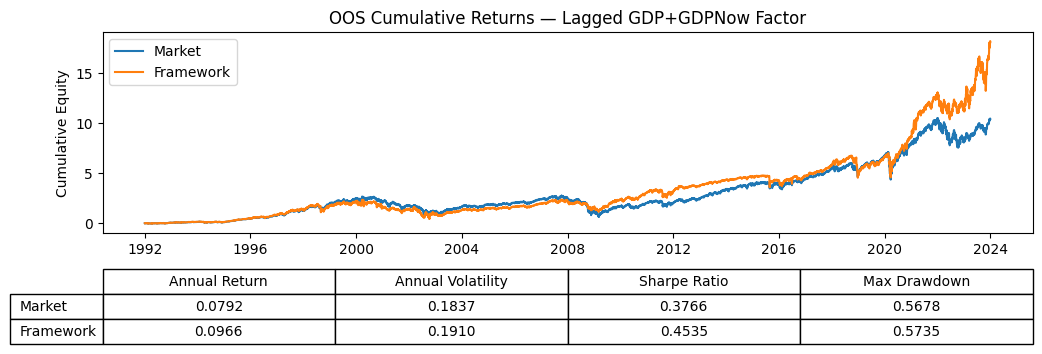

In [3220]:
import warnings
warnings.filterwarnings("ignore", message="Model is not converging")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from hmmlearn.hmm import GaussianHMM
import ruptures as rpt   # 用于结构性破裂检测

# ──────────────────────────────────────────────────────────────────
# 载入并预处理
# ──────────────────────────────────────────────────────────────────
df = df.loc[:'2023-12-31']
df['GDP'] = df['GDP'].fillna(method='ffill')

# GDPNow 从 2011‑11‑01 开始有值
first_gdpnow_date = df['GDPNow'].first_valid_index()
first_gdpnow_pos  = df.index.get_loc(first_gdpnow_date)

# ─── 1. 生成两套滞后：GDP 用 4 个月，GDPNow 用 1 个月 ───
df['GDP_lag120']    = df['GDP'].shift(120)   # 上一季度
df['GDPNow_lag30'] = df['GDPNow'].shift(30)  # 上个月

# ──────────────────────────────────────────────────────────────────
# 工具函数
# ──────────────────────────────────────────────────────────────────
# ─── 3. Sharpe 年化频率改为 12（月度） ───
def sharpe_ratio(log_returns, freq=12, rf=0.01):
    total_log  = np.sum(log_returns)
    annual_log = total_log * (freq / len(log_returns))
    annual_rtn = np.exp(annual_log) - 1
    vol_annual = np.std(log_returns, ddof=0) * np.sqrt(freq)
    return (annual_rtn - rf) / vol_annual

def max_drawdown(equity: pd.Series):
    dd = equity / equity.cummax() - 1
    return dd.min()

n_components = 3

# ──────────────────────────────────────────────────────────────────
# 扩张窗口 + 按年滚动测试，条件选特征
# ──────────────────────────────────────────────────────────────────
strategy_oos = []
metrics      = []
state_oos    = []
freq_history = []
exposures    = None
final_map    = None

for yr in range(1992, 2024):
    train_idx = df.index[df.index.year < yr]
    test_idx  = df.index[df.index.year == yr]

    if len(train_idx) < n_components or len(test_idx) == 0:
        continue

    # 如果训练集末端在 GDPNow 可用后 30 日，就用 GDPNow_lag30；否则用 GDP_lag120
    # ─── 2. 训练/测试时按可用性选择特征 ───
    last_loc = df.index.get_loc(train_idx[-1])
    if last_loc > first_gdpnow_pos + 1:          # 至少滞后 1 个周期后才能用 GDPNow
        feats = ['VolState', 'GDPNow_lag30']
    else:
        feats = ['VolState', 'GDP_lag120']

    # 构造训练/测试集
    X_tr_df = df[feats].loc[train_idx].dropna()
    y_tr_df = df.loc[X_tr_df.index, 'MarketReturn']
    X_te_df = df[feats].loc[test_idx].dropna()
    y_te_df = df.loc[X_te_df.index, 'MarketReturn']

    X_tr, y_tr = X_tr_df.values, y_tr_df.values
    X_te, y_te = X_te_df.values, y_te_df.values

    # 标准化
    scaler = StandardScaler().fit(X_tr)
    X_tr_s = scaler.transform(X_tr)
    X_te_s = scaler.transform(X_te)

    # 拟合 HMM
    model = GaussianHMM(
        n_components=n_components, covariance_type='diag',
        n_iter=200, tol=1e-2, random_state=0
    )
    model.min_covar = 1e-3
    model.fit(X_tr_s)

    # 状态频率 & 破裂检测
    states_tr = model.predict(X_tr_s)
    freq      = np.bincount(states_tr, minlength=n_components) / len(states_tr)
    freq_history.append(freq)
    retrain = False
    if len(freq_history) >= 10:
        bkps = rpt.Pelt(model="rbf") \
                  .fit(np.array(freq_history)[:, 0].reshape(-1, 1)) \
                  .predict(pen=1.0)
        retrain = (bkps and bkps[-1] == len(freq_history))

    # 校准 exposures
    if exposures is None or retrain:
        stats = []
        for s in range(n_components):
            mask   = (states_tr == s)
            if mask.sum() > 0:
                r      = y_tr[mask]
                mu     = r.mean()
                mad    = np.abs(r - mu).mean()
                vol    = r.std()
                sharpe = mu / vol if vol > 0 else np.nan
            else:
                mu = mad = vol = sharpe = np.nan
            stats.append({'state': s, 'mean': mu, 'mad': mad, 'vol': vol, 'sharpe': sharpe})
        df_stats        = pd.DataFrame(stats).set_index('state')
        df_stats['score']= (df_stats['sharpe'] + df_stats['mean'] / df_stats['mad']) / 2
        order           = df_stats['score'].sort_values().index.tolist()
        bear, side, bull= order
        exposures       = np.array([0.5, 1.0, 2.0])[np.argsort(order)]
        final_map       = (bear, side, bull)

    # OOS 隐状态 & 策略收益
    states_te  = model.predict(X_te_s)
    state_oos.append(pd.Series(states_te, index=X_te_df.index))
    strat_ret  = exposures[states_te] * y_te
    strategy_oos.append(pd.Series(strat_ret, index=X_te_df.index))

    # 性能指标
    mse       = mean_squared_error(y_te, strat_ret)
    mae       = mean_absolute_error(y_te, strat_ret)
    rmse      = np.sqrt(mse)
    denom     = np.clip(strat_ret**2, 1e-6, None)
    qlike     = np.mean((y_te**2)/denom - np.log((y_te**2)/denom) - 1)
    log_strat = np.log1p(strat_ret)
    sr        = sharpe_ratio(log_strat)
    eq        = (1 + pd.Series(strat_ret, index=X_te_df.index)).cumprod()
    mdd       = max_drawdown(eq)

    metrics.append({
        'year': yr, 'MSE': mse, 'MAE': mae,
        'RMSE': rmse, 'QLIKE': qlike, 'Sharpe': sr, 'MaxDD': mdd
    })

# ──────────────────────────────────────────────────────────────────
# 打印 & 可视化
# ──────────────────────────────────────────────────────────────────
bear, side, bull = final_map
print(f"最终映射 → bear={bear}, side={side}, bull={bull}")
print("OOS 隐状态预测次数：", pd.concat(state_oos).value_counts().sort_index().to_dict())

import matplotlib.gridspec as gridspec

# ─── 1. 对齐并提取 log‑returns ───
# market_log = 原始 df['MarketReturn'] (log returns)
# strat_log = strategy_oos 合并后的那一条 pd.Series
market_log = df['MarketReturn']
strat_log = pd.concat(strategy_oos).sort_index()

# 从两者共同的起始点开始
start = max(market_log.index.min(), strat_log.index.min())
mkt_log = market_log.loc[start: strat_log.index.max()]
fmk_log = strat_log

# ─── 2. 计算绩效指标 ───
def annual_return(log_rets, freq):
    tot = log_rets.sum()
    return np.exp(tot * (freq/len(log_rets))) - 1

freq = 252   # 如果是日度留 252，月度改成 12
perf = {}
for name, logs in [('Market', mkt_log), ('Framework', fmk_log)]:
    ann_ret = annual_return(logs, freq)
    ann_vol = np.std(logs, ddof=0) * np.sqrt(freq)
    sharpe  = sharpe_ratio(logs, freq=freq)
    eq      = np.exp(logs.cumsum())
    mdd     = max_drawdown(eq)
    perf[name] = [ann_ret, ann_vol, sharpe, abs(mdd)]

# 转成表格要的数据
row_labels = list(perf.keys())
col_labels = ['Annual Return', 'Annual Volatility', 'Sharpe Ratio', 'Max Drawdown']
cell_text  = [[f"{v:.4f}" for v in perf[r]] for r in row_labels]

# ─── 3. 绘图：上面净值曲线，下面表格 ───
fig = plt.figure(figsize=(12, 4))
gs  = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.3)

ax0 = fig.add_subplot(gs[0])
# 先把“基点 1”变成“基点 0”
cum_mkt = np.exp(mkt_log.cumsum()) - 1
cum_fmk = np.exp(fmk_log.cumsum()) - 1

ax0.plot(cum_mkt, label='Market')
ax0.plot(cum_fmk, label='Framework')


ax0.set_ylabel('Cumulative Return')

ax0.set_title('OOS Cumulative Returns — Lagged GDP+GDPNow Factor')
ax0.legend(loc='upper left')
ax0.set_ylabel('Cumulative Equity')

ax1 = fig.add_subplot(gs[1])
ax1.axis('off')
tbl = ax1.table(
    cellText=cell_text,
    rowLabels=row_labels,
    colLabels=col_labels,
    cellLoc='center',
    loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

plt.tight_layout()
plt.show()


volstate_Log_Return → bear=2, side=1, bull=0
State counts: 0    6895
1     320
2     844
Name: count, dtype: int64 

volstate_Credit Spread → bear=2, side=0, bull=1
State counts: 0    4028
1     588
2     669
Name: count, dtype: int64 

volstate_Gold Log → bear=2, side=0, bull=1
State counts: 0    3957
1    1402
2     408
Name: count, dtype: int64 



Model is not converging.  Current: 26815.659591834505 is not greater than 26815.65966489039. Delta is -7.305588587769307e-05
Model is not converging.  Current: 28943.10124675872 is not greater than 28943.10136955705. Delta is -0.00012279833026695997


volstate_VIX → bear=1, side=2, bull=0
State counts: 0    5053
1    1350
2    1656
Name: count, dtype: int64 



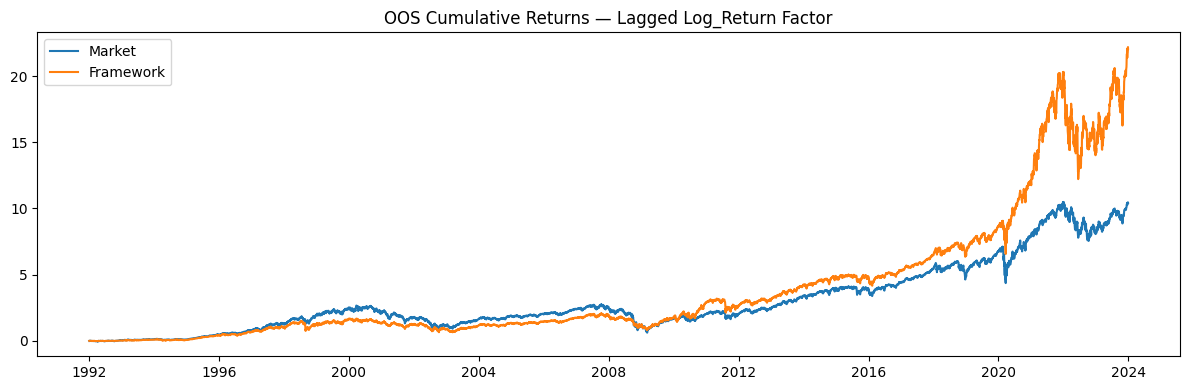

volstate_Log_Return Avg → Sharpe 0.82, MaxDD -13.9%



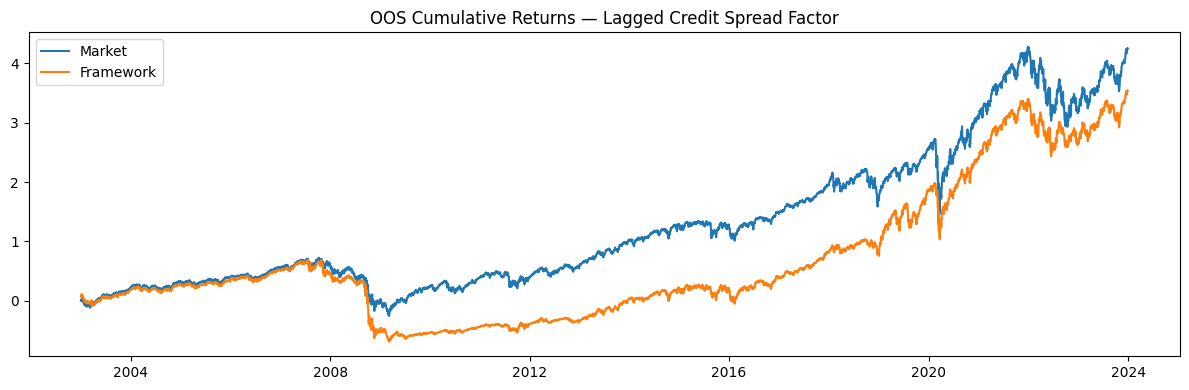

volstate_Credit Spread Avg → Sharpe 0.79, MaxDD -18.7%



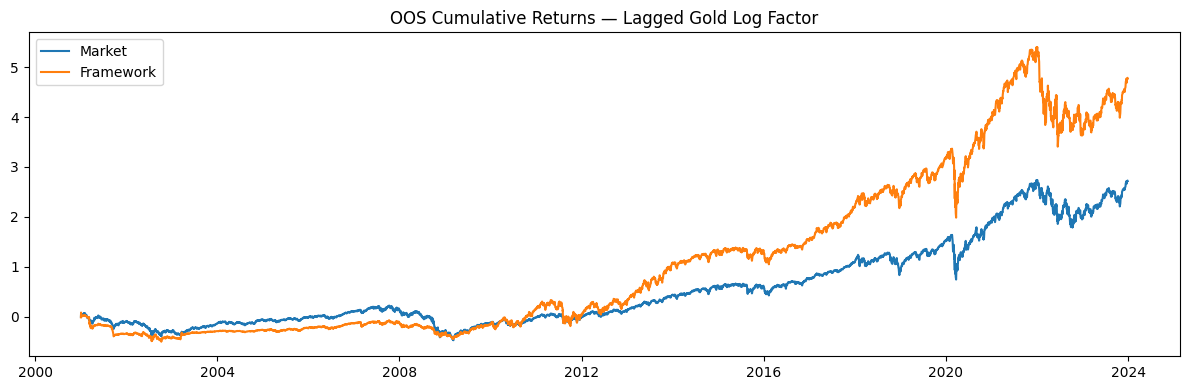

volstate_Gold Log Avg → Sharpe 0.71, MaxDD -16.6%



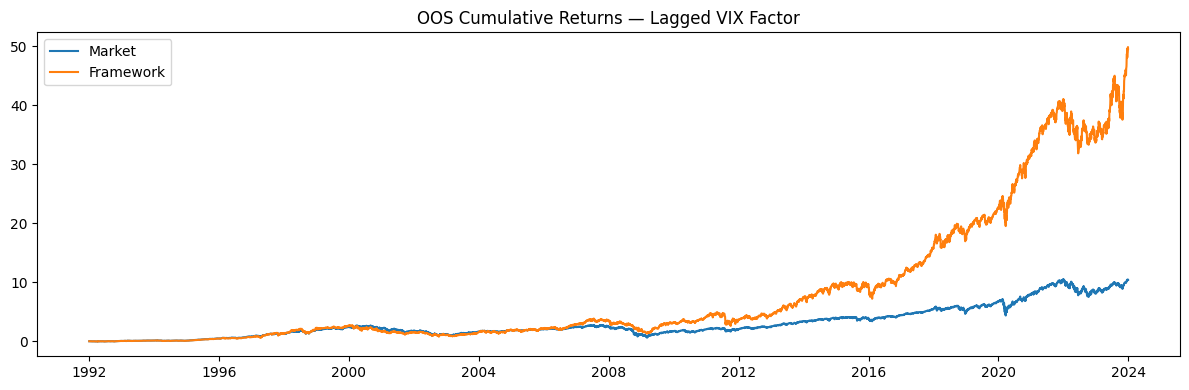

volstate_VIX Avg → Sharpe 0.90, MaxDD -16.2%

=== Performance Summary ===
                        Annual Return  Annual Volatility  Sharpe Ratio  \
Market                         0.0839             0.1907        0.3878   
volstate_Log_Return            0.1276             0.1996        0.5893   
volstate_Credit Spread         0.0748             0.2670        0.2425   
volstate_Gold Log              0.1175             0.2101        0.5119   
volstate_VIX                   0.1658             0.2340        0.6655   

                        Max Drawdown  
Market                        0.5678  
volstate_Log_Return           0.4104  
volstate_Credit Spread        0.8156  
volstate_Gold Log             0.3993  
volstate_VIX                  0.5188  


In [3221]:
import warnings
warnings.filterwarnings("ignore", message="Model is not converging")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from hmmlearn.hmm import GaussianHMM
import ruptures as rpt   # 用于结构性破裂检测


# ------------------------------------------------------------------
# 2 | Utility functions
# ------------------------------------------------------------------
def sharpe_ratio(log_returns, freq=252, rf=0.01):
    total_log  = np.sum(log_returns)
    annual_log = total_log * (freq / len(log_returns))
    annual_rtn = np.exp(annual_log) - 1
    vol_annual = np.std(log_returns, ddof=0) * np.sqrt(freq)
    return (annual_rtn - rf) / vol_annual

def max_drawdown(equity: pd.Series):
    dd = equity / equity.cummax() - 1
    return dd.min()

# ------------------------------------------------------------------
# 3 | Feature combos & 30‑day lag
# ------------------------------------------------------------------
combos = {
    'volstate_Log_Return': ['VolState', 'MarketReturn'],
    'volstate_Credit Spread':   ['VolState', 'credit_spread'],
    'volstate_Gold Log':   ['VolState', 'Gold_Log_Returns'],
    'volstate_VIX':   ['VolState', 'VIX']
}

# apply a 1‑day lag to all combo features
lag = 1
lag_cols = set().union(*combos.values())
df_lag = df.copy()
df_lag[list(lag_cols)] = df_lag[list(lag_cols)].shift(lag)

# ------------------------------------------------------------------
# 4 | Rolling forecasts with expanding‑window training by year
# ------------------------------------------------------------------
strategy_oos = {name: [] for name in combos}
metrics      = {name: [] for name in combos}
state_oos    = {name: [] for name in combos}

for name, feats in combos.items():
    # prepare full sample where all feat values are present
    X_all = df_lag[feats].dropna()
    y_all = df.loc[X_all.index, 'MarketReturn']

    freq_history = []
    exposures    = None
    final_map    = None

    # expanding window: train on all data before each year, test on that year
    for yr in range(1992, 2025):
        train_idx = X_all.index[X_all.index.year < yr]
        test_idx  = X_all.index[X_all.index.year == yr]

        # skip if insufficient data
        if len(train_idx) < 3 or len(test_idx) == 0:
            continue

        X_tr, y_tr = X_all.loc[train_idx].values, y_all.loc[train_idx].values
        X_te, y_te = X_all.loc[test_idx].values,  y_all.loc[test_idx].values

        # standardize
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr)
        X_te_s = scaler.transform(X_te)

        # fit HMM
        model = GaussianHMM(n_components=3, covariance_type='diag',
                            n_iter=200, tol=1e-2, random_state=0)
        model.min_covar = 1e-3
        model.fit(X_tr_s)

        # track state frequencies for break detection
        states_tr = model.predict(X_tr_s)
        freq      = np.bincount(states_tr, minlength=3) / len(states_tr)
        freq_history.append(freq)

        retrain = False
        if len(freq_history) >= 10:
            bkps = rpt.Pelt(model="rbf") \
                      .fit(np.array(freq_history)[:,0].reshape(-1,1)) \
                      .predict(pen=1.0)
            retrain = (bkps and bkps[-1] == len(freq_history))

        # calibrate exposures when first or after break
        if exposures is None or retrain:
            stats = []
            for s in range(3):
                mask = (states_tr == s)
                if mask.sum() > 0:
                    r      = y_tr[mask]
                    mu     = r.mean()
                    mad    = np.abs(r - mu).mean()
                    vol    = r.std()
                    sharpe = mu/vol if vol>0 else np.nan
                else:
                    mu = mad = vol = sharpe = np.nan
                stats.append({'state':s,'mean':mu,'mad':mad,'vol':vol,'sharpe':sharpe})
            df_stats       = pd.DataFrame(stats).set_index('state')
            df_stats['score']= (df_stats['sharpe'] + df_stats['mean']/df_stats['mad'])/2
            order          = df_stats['score'].sort_values().index.tolist()
            bear, side, bull = order
            exposures      = np.array([0.5,1.0,2.0])[np.argsort(order)]
            final_map      = (bear, side, bull)

        # OOS 隐状态 & 策略收益
        states_te = model.predict(X_te_s)
        # append to the per‑combo list, using test_idx for the index
        state_oos[name].append(pd.Series(states_te, index=test_idx))
        
        strat_ret = exposures[states_te] * y_te
        strategy_oos[name].append(pd.Series(strat_ret, index=test_idx))

        # record metrics
        mse   = mean_squared_error(y_te, strat_ret)
        mae   = mean_absolute_error(y_te, strat_ret)
        rmse  = np.sqrt(mse)
        denom = np.clip(strat_ret**2, 1e-6, None)
        qlike = np.mean((y_te**2)/denom - np.log((y_te**2)/denom) - 1)
        log_strat = np.log1p(strat_ret)
        sr        = sharpe_ratio(log_strat)
        eq    = (1 + pd.Series(strat_ret, index=test_idx)).cumprod()
        mdd   = max_drawdown(eq)

        metrics[name].append({
            'year': yr, 'MSE': mse, 'MAE': mae,
            'RMSE': rmse, 'QLIKE': qlike, 'Sharpe': sr, 'MaxDD': mdd
        })

    # print mapping & state distribution
    bear, side, bull = final_map
    print(f"{name} → bear={bear}, side={side}, bull={bull}")
    all_states = pd.concat(state_oos[name])
    print("State counts:", all_states.value_counts().sort_index(), "\n")

# ------------------------------------------------------------------
# 5 | Aggregate & plot (unchanged)
# ------------------------------------------------------------------
market_eq  = np.exp(df['MarketReturn'].cumsum())

for name in combos:
    strat = pd.concat(strategy_oos[name]).sort_index()
    
    # 原始的“累积净值”序列
    cum = (1 + strat).cumprod()
    
    # 把基点 1 → 0，得到“累积收益率”
    cum_return = cum - 1

    # 对齐 Market：先算 equity，再减 1
    mkt_eq    = market_eq.loc[cum_return.index.min():]
    mkt_return = mkt_eq / mkt_eq.iloc[0] - 1

    plt.figure(figsize=(12,4))
    plt.plot(mkt_return,    label='Market')
    plt.plot(cum_return,    label='Framework')
    
    # ←—— 这里改成动态 title
    factor = name.split('_', 1)[1]      # 'volstate_vix' → 'Vix'
    plt.title(f"OOS Cumulative Returns — Lagged {factor} Factor")
    
    plt.legend(); plt.tight_layout(); plt.show()

    dfm = pd.DataFrame(metrics[name]).set_index('year')
    avg = dfm.mean().to_dict()
    
    # 用同样的逻辑打印表格
    print(f"{name} Avg → Sharpe {avg['Sharpe']:.2f}, MaxDD {avg['MaxDD']*100:.1f}%\n")

import matplotlib.gridspec as gridspec

# ——— 5.1 annual_return 函数 ———
def annual_return(log_returns, freq=252):
    tot = np.sum(log_returns)
    return np.exp(tot * (freq / len(log_returns))) - 1

# ——— 5.2 收集 Market & 各策略的 log‑returns ———
log_rets = {'Market': df['MarketReturn']}
for name in combos:
    strat = pd.concat(strategy_oos[name]).sort_index()
    log_rets[name] = np.log1p(strat)

# 对齐起始点
start = max(series.index.min() for series in log_rets.values())

# ——— 5.3 计算绩效指标 ———
perf = {}
freq = 252  # 日度：252；月度改成 12
for name, logs in log_rets.items():
    logs = logs.loc[start:]
    ann_ret = annual_return(logs, freq)
    ann_vol = np.std(logs, ddof=0) * np.sqrt(freq)
    sharpe  = sharpe_ratio(logs, freq=freq)
    eq      = np.exp(logs.cumsum())
    mdd     = max_drawdown(eq)
    perf[name] = [ann_ret, ann_vol, sharpe, abs(mdd)]

# 转 pandas DataFrame 并打印
df_perf = pd.DataFrame.from_dict(
    perf, orient='index',
    columns=['Annual Return','Annual Volatility','Sharpe Ratio','Max Drawdown']
).round(4)

print("=== Performance Summary ===")
print(df_perf)

Model is not converging.  Current: 8960.324667571966 is not greater than 8960.324667634171. Delta is -6.22057996224612e-08


volstate_10-2 Treasury Difference → bear=1, side=2, bull=0
State counts: 0    6846
1     465
2     748
Name: count, dtype: int64 



Model is not converging.  Current: 23792.738161821402 is not greater than 23792.738161846457. Delta is -2.5054760044440627e-08


volstate_PMI → bear=0, side=1, bull=2
State counts: 0    6741
1     694
2     624
Name: count, dtype: int64 



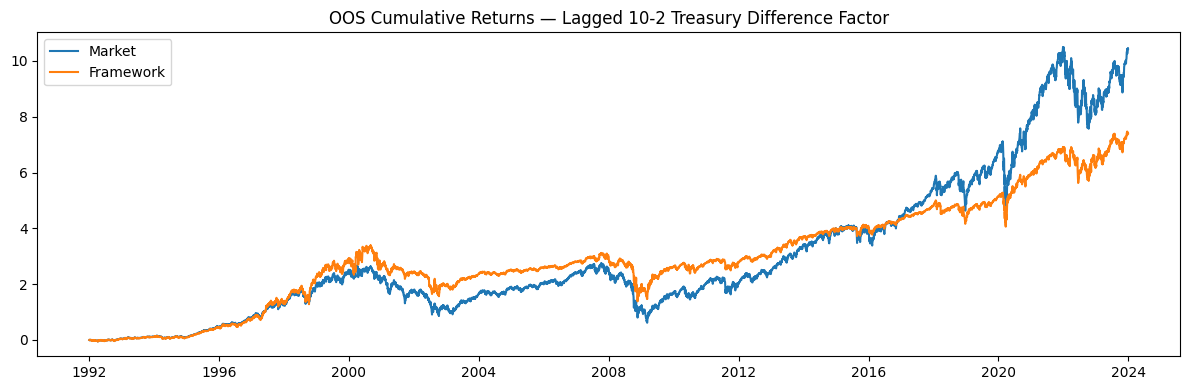

volstate_10-2 Treasury Difference Avg → Sharpe 0.77, MaxDD -10.4%



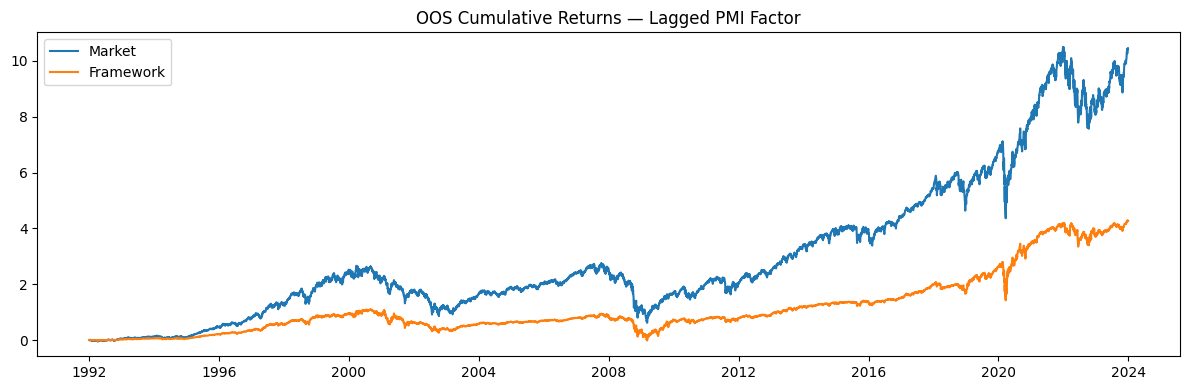

volstate_PMI Avg → Sharpe 0.73, MaxDD -10.2%

=== Performance Summary ===
                                   Annual Return  Annual Volatility  \
Market                                    0.0792             0.1837   
volstate_10-2 Treasury Difference         0.0688             0.1461   
volstate_PMI                              0.0534             0.1491   

                                   Sharpe Ratio  Max Drawdown  
Market                                   0.3766        0.5678  
volstate_10-2 Treasury Difference        0.4027        0.4576  
volstate_PMI                             0.2911        0.5308  


In [3222]:
import warnings
warnings.filterwarnings("ignore", message="Model is not converging")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from hmmlearn.hmm import GaussianHMM
import ruptures as rpt   # 用于结构性破裂检测

# ------------------------------------------------------------------
# 2 | Utility functions
# ------------------------------------------------------------------
def sharpe_ratio(log_returns, freq=252, rf=0.01):
    total_log  = np.sum(log_returns)
    annual_log = total_log * (freq / len(log_returns))
    annual_rtn = np.exp(annual_log) - 1
    vol_annual = np.std(log_returns, ddof=0) * np.sqrt(freq)
    return (annual_rtn - rf) / vol_annual

def max_drawdown(equity: pd.Series):
    dd = equity / equity.cummax() - 1
    return dd.min()

# ------------------------------------------------------------------
# 3 | Feature combos & 30‑day lag
# ------------------------------------------------------------------
combos = {
    'volstate_10-2 Treasury Difference': ['VolState', 'treasury_difference_10_2'],
    'volstate_PMI':   ['VolState', 'PMI']

}

# apply a 30‑day lag to all combo features
lag = 30
lag_cols = set().union(*combos.values())
df_lag = df.copy()
df_lag[list(lag_cols)] = df_lag[list(lag_cols)].shift(lag)

# ------------------------------------------------------------------
# 4 | Rolling forecasts with expanding‑window training by year
# ------------------------------------------------------------------
strategy_oos = {name: [] for name in combos}
metrics      = {name: [] for name in combos}
state_oos    = {name: [] for name in combos}

for name, feats in combos.items():
    # prepare full sample where all feat values are present
    X_all = df_lag[feats].dropna()
    y_all = df.loc[X_all.index, 'MarketReturn']

    freq_history = []
    exposures    = None
    final_map    = None

    # expanding window: train on all data before each year, test on that year
    for yr in range(1992, 2025):
        train_idx = X_all.index[X_all.index.year < yr]
        test_idx  = X_all.index[X_all.index.year == yr]

        # skip if insufficient data
        if len(train_idx) < 3 or len(test_idx) == 0:
            continue

        X_tr, y_tr = X_all.loc[train_idx].values, y_all.loc[train_idx].values
        X_te, y_te = X_all.loc[test_idx].values,  y_all.loc[test_idx].values

        # standardize
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr)
        X_te_s = scaler.transform(X_te)

        # fit HMM
        model = GaussianHMM(n_components=3, covariance_type='diag',
                            n_iter=200, tol=1e-2, random_state=0)
        model.min_covar = 1e-3
        model.fit(X_tr_s)

        # track state frequencies for break detection
        states_tr = model.predict(X_tr_s)
        freq      = np.bincount(states_tr, minlength=3) / len(states_tr)
        freq_history.append(freq)

        retrain = False
        if len(freq_history) >= 10:
            bkps = rpt.Pelt(model="rbf") \
                      .fit(np.array(freq_history)[:,0].reshape(-1,1)) \
                      .predict(pen=1.0)
            retrain = (bkps and bkps[-1] == len(freq_history))

        # calibrate exposures when first or after break
        if exposures is None or retrain:
            stats = []
            for s in range(3):
                mask = (states_tr == s)
                if mask.sum() > 0:
                    r      = y_tr[mask]
                    mu     = r.mean()
                    mad    = np.abs(r - mu).mean()
                    vol    = r.std()
                    sharpe = mu/vol if vol>0 else np.nan
                else:
                    mu = mad = vol = sharpe = np.nan
                stats.append({'state':s,'mean':mu,'mad':mad,'vol':vol,'sharpe':sharpe})
            df_stats       = pd.DataFrame(stats).set_index('state')
            df_stats['score']= (df_stats['sharpe'] + df_stats['mean']/df_stats['mad'])/2
            order          = df_stats['score'].sort_values().index.tolist()
            bear, side, bull = order
            exposures      = np.array([0.5,1.0,2.0])[np.argsort(order)]
            final_map      = (bear, side, bull)

        # OOS 隐状态 & 策略收益
        states_te = model.predict(X_te_s)
        # append to the per‑combo list, using test_idx for the index
        state_oos[name].append(pd.Series(states_te, index=test_idx))
        
        strat_ret = exposures[states_te] * y_te
        strategy_oos[name].append(pd.Series(strat_ret, index=test_idx))

        # record metrics
        mse   = mean_squared_error(y_te, strat_ret)
        mae   = mean_absolute_error(y_te, strat_ret)
        rmse  = np.sqrt(mse)
        denom = np.clip(strat_ret**2, 1e-6, None)
        qlike = np.mean((y_te**2)/denom - np.log((y_te**2)/denom) - 1)
        log_strat = np.log1p(strat_ret)
        sr        = sharpe_ratio(log_strat)
        eq    = (1 + pd.Series(strat_ret, index=test_idx)).cumprod()
        mdd   = max_drawdown(eq)

        metrics[name].append({
            'year': yr, 'MSE': mse, 'MAE': mae,
            'RMSE': rmse, 'QLIKE': qlike, 'Sharpe': sr, 'MaxDD': mdd
        })

    # print mapping & state distribution
    bear, side, bull = final_map
    print(f"{name} → bear={bear}, side={side}, bull={bull}")
    all_states = pd.concat(state_oos[name])
    print("State counts:", all_states.value_counts().sort_index(), "\n")

# ------------------------------------------------------------------
# 5 | Aggregate & plot (unchanged)
# ------------------------------------------------------------------
market_eq  = np.exp(df['MarketReturn'].cumsum())

for name in combos:
    strat = pd.concat(strategy_oos[name]).sort_index()
    
    # 原始的“累积净值”序列
    cum = (1 + strat).cumprod()
    
    # 把基点 1 → 0，得到“累积收益率”
    cum_return = cum - 1

    # 对齐 Market：先算 equity，再减 1
    mkt_eq    = market_eq.loc[cum_return.index.min():]
    mkt_return = mkt_eq / mkt_eq.iloc[0] - 1

    plt.figure(figsize=(12,4))
    plt.plot(mkt_return,    label='Market')
    plt.plot(cum_return,    label='Framework')
    
    # ←—— 这里改成动态 title
    factor = name.split('_', 1)[1]      # 'volstate_vix' → 'Vix'
    plt.title(f"OOS Cumulative Returns — Lagged {factor} Factor")
    
    plt.legend(); plt.tight_layout(); plt.show()

    dfm = pd.DataFrame(metrics[name]).set_index('year')
    avg = dfm.mean().to_dict()
    
    # 用同样的逻辑打印表格
    print(f"{name} Avg → Sharpe {avg['Sharpe']:.2f}, MaxDD {avg['MaxDD']*100:.1f}%\n")

import matplotlib.gridspec as gridspec

# ——— 5.1 annual_return 函数 ———
def annual_return(log_returns, freq=252):
    tot = np.sum(log_returns)
    return np.exp(tot * (freq / len(log_returns))) - 1

# ——— 5.2 收集 Market & 各策略的 log‑returns ———
log_rets = {'Market': df['MarketReturn']}
for name in combos:
    strat = pd.concat(strategy_oos[name]).sort_index()
    log_rets[name] = np.log1p(strat)

# 对齐起始点
start = max(series.index.min() for series in log_rets.values())

# ——— 5.3 计算绩效指标 ———
perf = {}
freq = 252  # 日度：252；月度改成 12
for name, logs in log_rets.items():
    logs = logs.loc[start:]
    ann_ret = annual_return(logs, freq)
    ann_vol = np.std(logs, ddof=0) * np.sqrt(freq)
    sharpe  = sharpe_ratio(logs, freq=freq)
    eq      = np.exp(logs.cumsum())
    mdd     = max_drawdown(eq)
    perf[name] = [ann_ret, ann_vol, sharpe, abs(mdd)]

# 转 pandas DataFrame 并打印
df_perf = pd.DataFrame.from_dict(
    perf, orient='index',
    columns=['Annual Return','Annual Volatility','Sharpe Ratio','Max Drawdown']
).round(4)

print("=== Performance Summary ===")
print(df_perf)
# 如果你想要 LaTeX 格式，你可以：
# print(df_perf.to_latex())


Model is not converging.  Current: 6186.652392656533 is not greater than 6186.652393009602. Delta is -3.5306857171235606e-07
Model is not converging.  Current: 14176.363574782685 is not greater than 14176.363574857522. Delta is -7.483686204068363e-08


volstate_Sentiment → bear=2, side=0, bull=1
State counts: 0    6290
1     832
2     683
Name: count, dtype: int64 



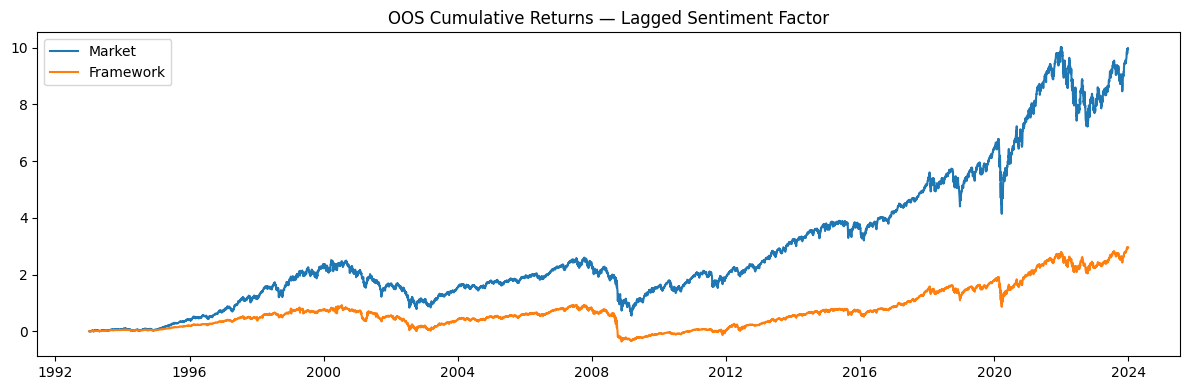

volstate_Sentiment Avg → Sharpe 0.74, MaxDD -13.8%

=== Performance Summary ===
                    Annual Return  Annual Volatility  Sharpe Ratio  \
Market                     0.0803             0.1858        0.3785   
volstate_Sentiment         0.0454             0.1792        0.1977   

                    Max Drawdown  
Market                    0.5678  
volstate_Sentiment        0.6690  


In [3223]:
import warnings
warnings.filterwarnings("ignore", message="Model is not converging")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from hmmlearn.hmm import GaussianHMM
import ruptures as rpt   # 用于结构性破裂检测



# ------------------------------------------------------------------
# 2 | Utility functions
# ------------------------------------------------------------------
def sharpe_ratio(log_returns, freq=252, rf=0.01):
    total_log  = np.sum(log_returns)
    annual_log = total_log * (freq / len(log_returns))
    annual_rtn = np.exp(annual_log) - 1
    vol_annual = np.std(log_returns, ddof=0) * np.sqrt(freq)
    return (annual_rtn - rf) / vol_annual

def max_drawdown(equity: pd.Series):
    dd = equity / equity.cummax() - 1
    return dd.min()

# ------------------------------------------------------------------
# 3 | Feature combos & 30‑day lag
# ------------------------------------------------------------------
combos = {
    'volstate_Sentiment': ['VolState', 'sentiment_score']
}

# apply a 90‑day lag to all combo features
lag = 90
lag_cols = set().union(*combos.values())
df_lag = df.copy()
df_lag[list(lag_cols)] = df_lag[list(lag_cols)].shift(lag)

# ------------------------------------------------------------------
# 4 | Rolling forecasts with expanding‑window training by year
# ------------------------------------------------------------------
strategy_oos = {name: [] for name in combos}
metrics      = {name: [] for name in combos}
state_oos    = {name: [] for name in combos}

for name, feats in combos.items():
    # prepare full sample where all feat values are present
    X_all = df_lag[feats].dropna()
    y_all = df.loc[X_all.index, 'MarketReturn']

    freq_history = []
    exposures    = None
    final_map    = None

    # expanding window: train on all data before each year, test on that year
    for yr in range(1992, 2025):
        train_idx = X_all.index[X_all.index.year < yr]
        test_idx  = X_all.index[X_all.index.year == yr]

        # skip if insufficient data
        if len(train_idx) < 3 or len(test_idx) == 0:
            continue

        X_tr, y_tr = X_all.loc[train_idx].values, y_all.loc[train_idx].values
        X_te, y_te = X_all.loc[test_idx].values,  y_all.loc[test_idx].values

        # standardize
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr)
        X_te_s = scaler.transform(X_te)

        # fit HMM
        model = GaussianHMM(n_components=3, covariance_type='diag',
                            n_iter=200, tol=1e-2, random_state=0)
        model.min_covar = 1e-3
        model.fit(X_tr_s)

        # track state frequencies for break detection
        states_tr = model.predict(X_tr_s)
        freq      = np.bincount(states_tr, minlength=3) / len(states_tr)
        freq_history.append(freq)

        retrain = False
        if len(freq_history) >= 10:
            bkps = rpt.Pelt(model="rbf") \
                      .fit(np.array(freq_history)[:,0].reshape(-1,1)) \
                      .predict(pen=1.0)
            retrain = (bkps and bkps[-1] == len(freq_history))

        # calibrate exposures when first or after break
        if exposures is None or retrain:
            stats = []
            for s in range(3):
                mask = (states_tr == s)
                if mask.sum() > 0:
                    r      = y_tr[mask]
                    mu     = r.mean()
                    mad    = np.abs(r - mu).mean()
                    vol    = r.std()
                    sharpe = mu/vol if vol>0 else np.nan
                else:
                    mu = mad = vol = sharpe = np.nan
                stats.append({'state':s,'mean':mu,'mad':mad,'vol':vol,'sharpe':sharpe})
            df_stats       = pd.DataFrame(stats).set_index('state')
            df_stats['score']= (df_stats['sharpe'] + df_stats['mean']/df_stats['mad'])/2
            order          = df_stats['score'].sort_values().index.tolist()
            bear, side, bull = order
            exposures      = np.array([0.5,1.0,2.0])[np.argsort(order)]
            final_map      = (bear, side, bull)

        # OOS 隐状态 & 策略收益
        states_te = model.predict(X_te_s)
        # append to the per‑combo list, using test_idx for the index
        state_oos[name].append(pd.Series(states_te, index=test_idx))
        
        strat_ret = exposures[states_te] * y_te
        strategy_oos[name].append(pd.Series(strat_ret, index=test_idx))

        # record metrics
        mse   = mean_squared_error(y_te, strat_ret)
        mae   = mean_absolute_error(y_te, strat_ret)
        rmse  = np.sqrt(mse)
        denom = np.clip(strat_ret**2, 1e-6, None)
        qlike = np.mean((y_te**2)/denom - np.log((y_te**2)/denom) - 1)
        log_strat = np.log1p(strat_ret)
        sr        = sharpe_ratio(log_strat)
        eq    = (1 + pd.Series(strat_ret, index=test_idx)).cumprod()
        mdd   = max_drawdown(eq)

        metrics[name].append({
            'year': yr, 'MSE': mse, 'MAE': mae,
            'RMSE': rmse, 'QLIKE': qlike, 'Sharpe': sr, 'MaxDD': mdd
        })

    # print mapping & state distribution
    bear, side, bull = final_map
    print(f"{name} → bear={bear}, side={side}, bull={bull}")
    all_states = pd.concat(state_oos[name])
    print("State counts:", all_states.value_counts().sort_index(), "\n")


# ------------------------------------------------------------------
# 5 | Aggregate & plot (unchanged)
# ------------------------------------------------------------------
market_eq  = np.exp(df['MarketReturn'].cumsum())

for name in combos:
    strat = pd.concat(strategy_oos[name]).sort_index()
    
    # 原始的“累积净值”序列
    cum = (1 + strat).cumprod()
    
    # 把基点 1 → 0，得到“累积收益率”
    cum_return = cum - 1

    # 对齐 Market：先算 equity，再减 1
    mkt_eq    = market_eq.loc[cum_return.index.min():]
    mkt_return = mkt_eq / mkt_eq.iloc[0] - 1

    plt.figure(figsize=(12,4))
    plt.plot(mkt_return,    label='Market')
    plt.plot(cum_return,    label='Framework')
    
    # ←—— 这里改成动态 title
    factor = name.split('_', 1)[1]      # 'volstate_vix' → 'Vix'
    plt.title(f"OOS Cumulative Returns — Lagged {factor} Factor")
    
    plt.legend(); plt.tight_layout(); plt.show()

    dfm = pd.DataFrame(metrics[name]).set_index('year')
    avg = dfm.mean().to_dict()
    
    # 用同样的逻辑打印表格
    print(f"{name} Avg → Sharpe {avg['Sharpe']:.2f}, MaxDD {avg['MaxDD']*100:.1f}%\n")

import matplotlib.gridspec as gridspec

# ——— 5.1 annual_return 函数 ———
def annual_return(log_returns, freq=252):
    tot = np.sum(log_returns)
    return np.exp(tot * (freq / len(log_returns))) - 1

# ——— 5.2 收集 Market & 各策略的 log‑returns ———
log_rets = {'Market': df['MarketReturn']}
for name in combos:
    strat = pd.concat(strategy_oos[name]).sort_index()
    log_rets[name] = np.log1p(strat)

# 对齐起始点
start = max(series.index.min() for series in log_rets.values())

# ——— 5.3 计算绩效指标 ———
perf = {}
freq = 252  # 日度：252；月度改成 12
for name, logs in log_rets.items():
    logs = logs.loc[start:]
    ann_ret = annual_return(logs, freq)
    ann_vol = np.std(logs, ddof=0) * np.sqrt(freq)
    sharpe  = sharpe_ratio(logs, freq=freq)
    eq      = np.exp(logs.cumsum())
    mdd     = max_drawdown(eq)
    perf[name] = [ann_ret, ann_vol, sharpe, abs(mdd)]

# 转 pandas DataFrame 并打印
df_perf = pd.DataFrame.from_dict(
    perf, orient='index',
    columns=['Annual Return','Annual Volatility','Sharpe Ratio','Max Drawdown']
).round(4)

print("=== Performance Summary ===")
print(df_perf)

volstate_GDP → bear=0, side=1, bull=2
State counts: 0    6716
1    1005
2     338
Name: count, dtype: int64 



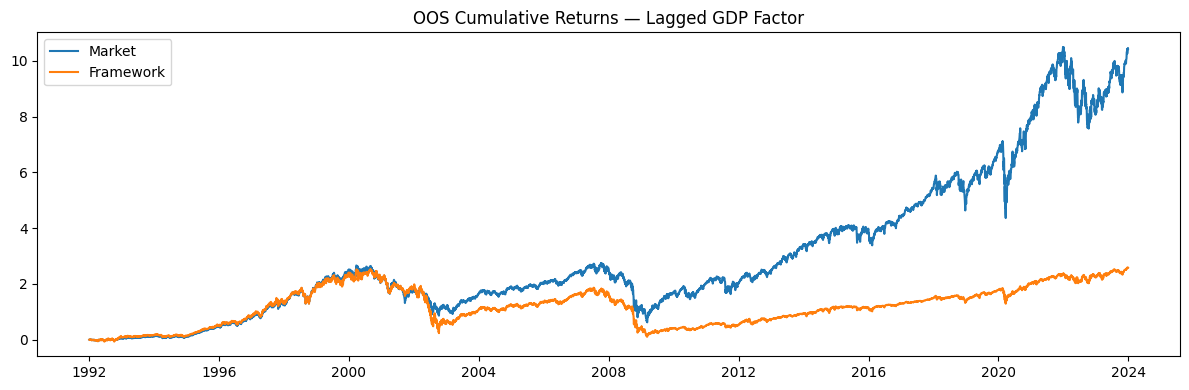

volstate_GDP Avg → Sharpe 0.70, MaxDD -12.7%

=== Performance Summary ===
              Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown
Market               0.0792             0.1837        0.3766        0.5678
volstate_GDP         0.0407             0.1681        0.1828        0.6855


In [3225]:
import warnings
warnings.filterwarnings("ignore", message="Model is not converging")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from hmmlearn.hmm import GaussianHMM
import ruptures as rpt   # 用于结构性破裂检测


# ------------------------------------------------------------------
# 2 | Utility functions
# ------------------------------------------------------------------
def sharpe_ratio(log_returns, freq=252, rf=0.01):
    total_log  = np.sum(log_returns)
    annual_log = total_log * (freq / len(log_returns))
    annual_rtn = np.exp(annual_log) - 1
    vol_annual = np.std(log_returns, ddof=0) * np.sqrt(freq)
    return (annual_rtn - rf) / vol_annual

def max_drawdown(equity: pd.Series):
    dd = equity / equity.cummax() - 1
    return dd.min()

# ------------------------------------------------------------------
# 3 | Feature combos & 30‑day lag
# ------------------------------------------------------------------
combos = {
    'volstate_GDP': ['VolState', 'GDP']
}

# apply a 1‑day lag to all combo features
lag = 120
lag_cols = set().union(*combos.values())
df_lag = df.copy()
df_lag[list(lag_cols)] = df_lag[list(lag_cols)].shift(lag)

# ------------------------------------------------------------------
# 4 | Rolling forecasts with expanding‑window training by year
# ------------------------------------------------------------------
strategy_oos = {name: [] for name in combos}
metrics      = {name: [] for name in combos}
state_oos    = {name: [] for name in combos}

for name, feats in combos.items():
    # prepare full sample where all feat values are present
    X_all = df_lag[feats].dropna()
    y_all = df.loc[X_all.index, 'MarketReturn']

    freq_history = []
    exposures    = None
    final_map    = None

    # expanding window: train on all data before each year, test on that year
    for yr in range(1992, 2025):
        train_idx = X_all.index[X_all.index.year < yr]
        test_idx  = X_all.index[X_all.index.year == yr]

        # skip if insufficient data
        if len(train_idx) < 3 or len(test_idx) == 0:
            continue

        X_tr, y_tr = X_all.loc[train_idx].values, y_all.loc[train_idx].values
        X_te, y_te = X_all.loc[test_idx].values,  y_all.loc[test_idx].values

        # standardize
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr)
        X_te_s = scaler.transform(X_te)

        # fit HMM
        model = GaussianHMM(n_components=3, covariance_type='diag',
                            n_iter=200, tol=1e-2, random_state=0)
        model.min_covar = 1e-3
        model.fit(X_tr_s)

        # track state frequencies for break detection
        states_tr = model.predict(X_tr_s)
        freq      = np.bincount(states_tr, minlength=3) / len(states_tr)
        freq_history.append(freq)

        retrain = False
        if len(freq_history) >= 10:
            bkps = rpt.Pelt(model="rbf") \
                      .fit(np.array(freq_history)[:,0].reshape(-1,1)) \
                      .predict(pen=1.0)
            retrain = (bkps and bkps[-1] == len(freq_history))

        # calibrate exposures when first or after break
        if exposures is None or retrain:
            stats = []
            for s in range(3):
                mask = (states_tr == s)
                if mask.sum() > 0:
                    r      = y_tr[mask]
                    mu     = r.mean()
                    mad    = np.abs(r - mu).mean()
                    vol    = r.std()
                    sharpe = mu/vol if vol>0 else np.nan
                else:
                    mu = mad = vol = sharpe = np.nan
                stats.append({'state':s,'mean':mu,'mad':mad,'vol':vol,'sharpe':sharpe})
            df_stats       = pd.DataFrame(stats).set_index('state')
            df_stats['score']= (df_stats['sharpe'] + df_stats['mean']/df_stats['mad'])/2
            order          = df_stats['score'].sort_values().index.tolist()
            bear, side, bull = order
            exposures      = np.array([0.5,1.0,2.0])[np.argsort(order)]
            final_map      = (bear, side, bull)

        # OOS 隐状态 & 策略收益
        states_te = model.predict(X_te_s)
        # append to the per‑combo list, using test_idx for the index
        state_oos[name].append(pd.Series(states_te, index=test_idx))
        
        strat_ret = exposures[states_te] * y_te
        strategy_oos[name].append(pd.Series(strat_ret, index=test_idx))

        # record metrics
        mse   = mean_squared_error(y_te, strat_ret)
        mae   = mean_absolute_error(y_te, strat_ret)
        rmse  = np.sqrt(mse)
        denom = np.clip(strat_ret**2, 1e-6, None)
        qlike = np.mean((y_te**2)/denom - np.log((y_te**2)/denom) - 1)
        log_strat = np.log1p(strat_ret)
        sr        = sharpe_ratio(log_strat)
        eq    = (1 + pd.Series(strat_ret, index=test_idx)).cumprod()
        mdd   = max_drawdown(eq)

        metrics[name].append({
            'year': yr, 'MSE': mse, 'MAE': mae,
            'RMSE': rmse, 'QLIKE': qlike, 'Sharpe': sr, 'MaxDD': mdd
        })

    # print mapping & state distribution
    bear, side, bull = final_map
    print(f"{name} → bear={bear}, side={side}, bull={bull}")
    all_states = pd.concat(state_oos[name])
    print("State counts:", all_states.value_counts().sort_index(), "\n")

# ------------------------------------------------------------------
# 5 | Aggregate & plot (unchanged)
# ------------------------------------------------------------------
market_eq  = np.exp(df['MarketReturn'].cumsum())

for name in combos:
    strat = pd.concat(strategy_oos[name]).sort_index()
    
    # 原始的“累积净值”序列
    cum = (1 + strat).cumprod()
    
    # 把基点 1 → 0，得到“累积收益率”
    cum_return = cum - 1

    # 对齐 Market：先算 equity，再减 1
    mkt_eq    = market_eq.loc[cum_return.index.min():]
    mkt_return = mkt_eq / mkt_eq.iloc[0] - 1

    plt.figure(figsize=(12,4))
    plt.plot(mkt_return,    label='Market')
    plt.plot(cum_return,    label='Framework')

    
    # ←—— 这里改成动态 title
    factor = name.split('_', 1)[1]      # 'volstate_vix' → 'Vix'
    plt.title(f"OOS Cumulative Returns — Lagged {factor} Factor")
    
    plt.legend(); plt.tight_layout(); plt.show()

    dfm = pd.DataFrame(metrics[name]).set_index('year')
    avg = dfm.mean().to_dict()
    
    # 用同样的逻辑打印表格
    print(f"{name} Avg → Sharpe {avg['Sharpe']:.2f}, MaxDD {avg['MaxDD']*100:.1f}%\n")

import matplotlib.gridspec as gridspec

# ——— 5.1 annual_return 函数 ———
def annual_return(log_returns, freq=252):
    tot = np.sum(log_returns)
    return np.exp(tot * (freq / len(log_returns))) - 1

# ——— 5.2 收集 Market & 各策略的 log‑returns ———
log_rets = {'Market': df['MarketReturn']}
for name in combos:
    strat = pd.concat(strategy_oos[name]).sort_index()
    log_rets[name] = np.log1p(strat)

# 对齐起始点
start = max(series.index.min() for series in log_rets.values())

# ——— 5.3 计算绩效指标 ———
perf = {}
freq = 252  # 日度：252；月度改成 12
for name, logs in log_rets.items():
    logs = logs.loc[start:]
    ann_ret = annual_return(logs, freq)
    ann_vol = np.std(logs, ddof=0) * np.sqrt(freq)
    sharpe  = sharpe_ratio(logs, freq=freq)
    eq      = np.exp(logs.cumsum())
    mdd     = max_drawdown(eq)
    perf[name] = [ann_ret, ann_vol, sharpe, abs(mdd)]

# 转 pandas DataFrame 并打印
df_perf = pd.DataFrame.from_dict(
    perf, orient='index',
    columns=['Annual Return','Annual Volatility','Sharpe Ratio','Max Drawdown']
).round(4)

print("=== Performance Summary ===")
print(df_perf)

# Monthly

In [3227]:
df = monthly_df

Fitting a model with 20 free scalar parameters with only 16 data points will result in a degenerate solution.
Model is not converging.  Current: 259.0993051789342 is not greater than 259.1267875504393. Delta is -0.027482371505129777
Model is not converging.  Current: 9.041972917162727 is not greater than 10.681487732626948. Delta is -1.6395148154642207


最终映射 → bear=2, side=1, bull=0
OOS 隐状态预测次数： {0: 336, 1: 14, 2: 34}


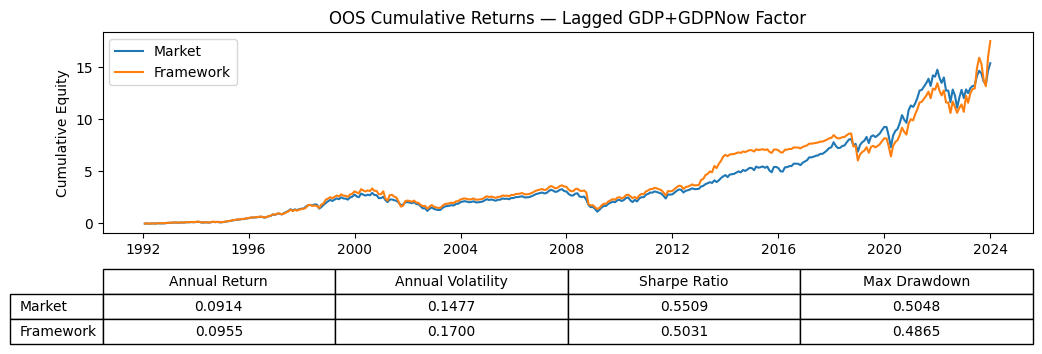

In [3233]:
import warnings
warnings.filterwarnings("ignore", message="Model is not converging")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from hmmlearn.hmm import GaussianHMM
import ruptures as rpt   # 用于结构性破裂检测

# ──────────────────────────────────────────────────────────────────
# 载入并预处理
# ──────────────────────────────────────────────────────────────────
df = df.loc[:'2023-12-31']
df['GDP'] = df['GDP'].fillna(method='ffill')

# GDPNow 从 2011‑11‑01 开始有值
first_gdpnow_date = df['GDPNow'].first_valid_index()
first_gdpnow_pos  = df.index.get_loc(first_gdpnow_date)

# ─── 1. 生成两套滞后：GDP 用 4 个月，GDPNow 用 1 个月 ───
df['GDP_lag4']    = df['GDP'].shift(4)   # 上一季度
df['GDPNow_lag1'] = df['GDPNow'].shift(1)  # 上个月

# ──────────────────────────────────────────────────────────────────
# 工具函数
# ──────────────────────────────────────────────────────────────────
# ─── 3. Sharpe 年化频率改为 12（月度） ───
def sharpe_ratio(log_returns, freq=12, rf=0.01):
    total_log  = np.sum(log_returns)
    annual_log = total_log * (freq / len(log_returns))
    annual_rtn = np.exp(annual_log) - 1
    vol_annual = np.std(log_returns, ddof=0) * np.sqrt(freq)
    return (annual_rtn - rf) / vol_annual

def max_drawdown(equity: pd.Series):
    dd = equity / equity.cummax() - 1
    return dd.min()

n_components = 3

# ──────────────────────────────────────────────────────────────────
# 扩张窗口 + 按年滚动测试，条件选特征
# ──────────────────────────────────────────────────────────────────
strategy_oos = []
metrics      = []
state_oos    = []
freq_history = []
exposures    = None
final_map    = None

for yr in range(1992, 2024):
    train_idx = df.index[df.index.year < yr]
    test_idx  = df.index[df.index.year == yr]

    if len(train_idx) < n_components or len(test_idx) == 0:
        continue

    # 如果训练集末端在 GDPNow 可用后 30 日，就用 GDPNow_lag30；否则用 GDP_lag120
    # ─── 2. 训练/测试时按可用性选择特征 ───
    last_loc = df.index.get_loc(train_idx[-1])
    if last_loc > first_gdpnow_pos + 1:          # 至少滞后 1 个周期后才能用 GDPNow
        feats = ['VolState', 'GDPNow_lag1']
    else:
        feats = ['VolState', 'GDP_lag4']

    # 构造训练/测试集
    X_tr_df = df[feats].loc[train_idx].dropna()
    y_tr_df = df.loc[X_tr_df.index, 'MarketReturn']
    X_te_df = df[feats].loc[test_idx].dropna()
    y_te_df = df.loc[X_te_df.index, 'MarketReturn']

    X_tr, y_tr = X_tr_df.values, y_tr_df.values
    X_te, y_te = X_te_df.values, y_te_df.values

    # 标准化
    scaler = StandardScaler().fit(X_tr)
    X_tr_s = scaler.transform(X_tr)
    X_te_s = scaler.transform(X_te)

    # 拟合 HMM
    model = GaussianHMM(
        n_components=n_components, covariance_type='diag',
        n_iter=200, tol=1e-2, random_state=0
    )
    model.min_covar = 1e-3
    model.fit(X_tr_s)

    # 状态频率 & 破裂检测
    states_tr = model.predict(X_tr_s)
    freq      = np.bincount(states_tr, minlength=n_components) / len(states_tr)
    freq_history.append(freq)
    retrain = False
    if len(freq_history) >= 10:
        bkps = rpt.Pelt(model="rbf") \
                  .fit(np.array(freq_history)[:, 0].reshape(-1, 1)) \
                  .predict(pen=1.0)
        retrain = (bkps and bkps[-1] == len(freq_history))

    # 校准 exposures
    if exposures is None or retrain:
        stats = []
        for s in range(n_components):
            mask   = (states_tr == s)
            if mask.sum() > 0:
                r      = y_tr[mask]
                mu     = r.mean()
                mad    = np.abs(r - mu).mean()
                vol    = r.std()
                sharpe = mu / vol if vol > 0 else np.nan
            else:
                mu = mad = vol = sharpe = np.nan
            stats.append({'state': s, 'mean': mu, 'mad': mad, 'vol': vol, 'sharpe': sharpe})
        df_stats        = pd.DataFrame(stats).set_index('state')
        df_stats['score']= (df_stats['sharpe'] + df_stats['mean'] / df_stats['mad']) / 2
        order           = df_stats['score'].sort_values().index.tolist()
        bear, side, bull= order
        exposures       = np.array([0.5, 1.0, 2.0])[np.argsort(order)]
        final_map       = (bear, side, bull)

    # OOS 隐状态 & 策略收益
    states_te  = model.predict(X_te_s)
    state_oos.append(pd.Series(states_te, index=X_te_df.index))
    strat_ret  = exposures[states_te] * y_te
    strategy_oos.append(pd.Series(strat_ret, index=X_te_df.index))

    # 性能指标
    mse       = mean_squared_error(y_te, strat_ret)
    mae       = mean_absolute_error(y_te, strat_ret)
    rmse      = np.sqrt(mse)
    denom     = np.clip(strat_ret**2, 1e-6, None)
    qlike     = np.mean((y_te**2)/denom - np.log((y_te**2)/denom) - 1)
    log_strat = np.log1p(strat_ret)
    sr        = sharpe_ratio(log_strat)
    eq        = (1 + pd.Series(strat_ret, index=X_te_df.index)).cumprod()
    mdd       = max_drawdown(eq)

    metrics.append({
        'year': yr, 'MSE': mse, 'MAE': mae,
        'RMSE': rmse, 'QLIKE': qlike, 'Sharpe': sr, 'MaxDD': mdd
    })

# ──────────────────────────────────────────────────────────────────
# 打印 & 可视化
# ──────────────────────────────────────────────────────────────────
bear, side, bull = final_map
print(f"最终映射 → bear={bear}, side={side}, bull={bull}")
print("OOS 隐状态预测次数：", pd.concat(state_oos).value_counts().sort_index().to_dict())

import matplotlib.gridspec as gridspec

# ─── 1. 对齐并提取 log‑returns ───
# market_log = 原始 df['MarketReturn'] (log returns)
# strat_log = strategy_oos 合并后的那一条 pd.Series
market_log = df['MarketReturn']
strat_log = pd.concat(strategy_oos).sort_index()

# 从两者共同的起始点开始
start = max(market_log.index.min(), strat_log.index.min())
mkt_log = market_log.loc[start: strat_log.index.max()]
fmk_log = strat_log

# ─── 2. 计算绩效指标 ───
def annual_return(log_rets, freq):
    tot = log_rets.sum()
    return np.exp(tot * (freq/len(log_rets))) - 1

freq = 12   # 如果是日度留 252，月度改成 12
perf = {}
for name, logs in [('Market', mkt_log), ('Framework', fmk_log)]:
    ann_ret = annual_return(logs, freq)
    ann_vol = np.std(logs, ddof=0) * np.sqrt(freq)
    sharpe  = sharpe_ratio(logs, freq=freq)
    eq      = np.exp(logs.cumsum())
    mdd     = max_drawdown(eq)
    perf[name] = [ann_ret, ann_vol, sharpe, abs(mdd)]

# 转成表格要的数据
row_labels = list(perf.keys())
col_labels = ['Annual Return', 'Annual Volatility', 'Sharpe Ratio', 'Max Drawdown']
cell_text  = [[f"{v:.4f}" for v in perf[r]] for r in row_labels]

# ─── 3. 绘图：上面净值曲线，下面表格 ───
fig = plt.figure(figsize=(12, 4))
gs  = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.3)

ax0 = fig.add_subplot(gs[0])
# 先把“基点 1”变成“基点 0”
cum_mkt = np.exp(mkt_log.cumsum()) - 1
cum_fmk = np.exp(fmk_log.cumsum()) - 1

ax0.plot(cum_mkt, label='Market')
ax0.plot(cum_fmk, label='Framework')

ax0.set_ylabel('Cumulative Return')

ax0.set_title('OOS Cumulative Returns — Lagged GDP+GDPNow Factor')
ax0.legend(loc='upper left')
ax0.set_ylabel('Cumulative Equity')

ax1 = fig.add_subplot(gs[1])
ax1.axis('off')
tbl = ax1.table(
    cellText=cell_text,
    rowLabels=row_labels,
    colLabels=col_labels,
    cellLoc='center',
    loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

plt.tight_layout()
plt.show()


Model is not converging.  Current: 7.6273705589479475 is not greater than 10.73533770436283. Delta is -3.107967145414883
Model is not converging.  Current: 820.4708329900277 is not greater than 820.4713523252307. Delta is -0.0005193352029664311
Fitting a model with 20 free scalar parameters with only 10 data points will result in a degenerate solution.


volstate_Lag-1 S&P-500 → bear=1, side=0, bull=2
State counts: 0    333
1     14
2     37
Name: count, dtype: int64 



Fitting a model with 20 free scalar parameters with only 8 data points will result in a degenerate solution.


volstate_Credit Spread → bear=0, side=2, bull=1
State counts: 0    183
1     33
2     36
Name: count, dtype: int64 



Model is not converging.  Current: 9.530957238666119 is not greater than 11.363426591781472. Delta is -1.8324693531153535


volstate_Gold Log → bear=0, side=2, bull=1
State counts: 0    206
1     28
2     42
Name: count, dtype: int64 

volstate_VIX → bear=1, side=0, bull=2
State counts: 0    281
1     40
2     63
Name: count, dtype: int64 



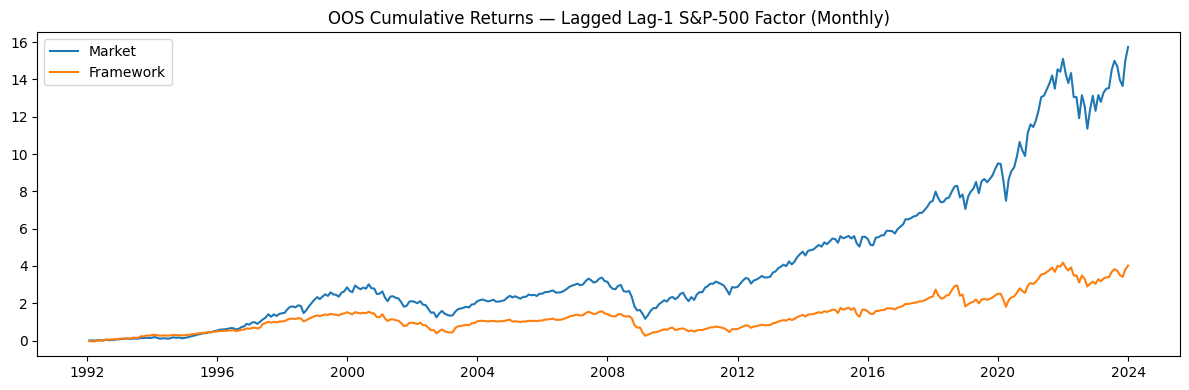

volstate_Lag-1 S&P-500 Avg → Sharpe 1.00, MaxDD -9.2%



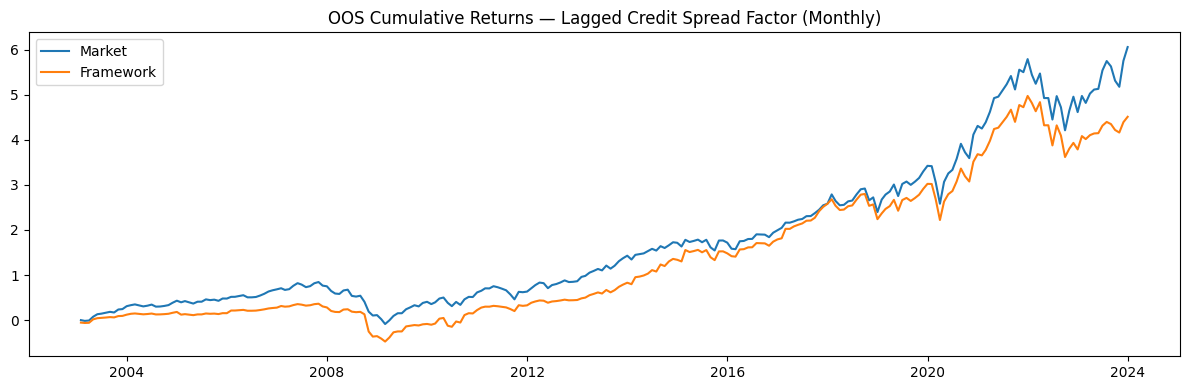

volstate_Credit Spread Avg → Sharpe 1.12, MaxDD -9.0%



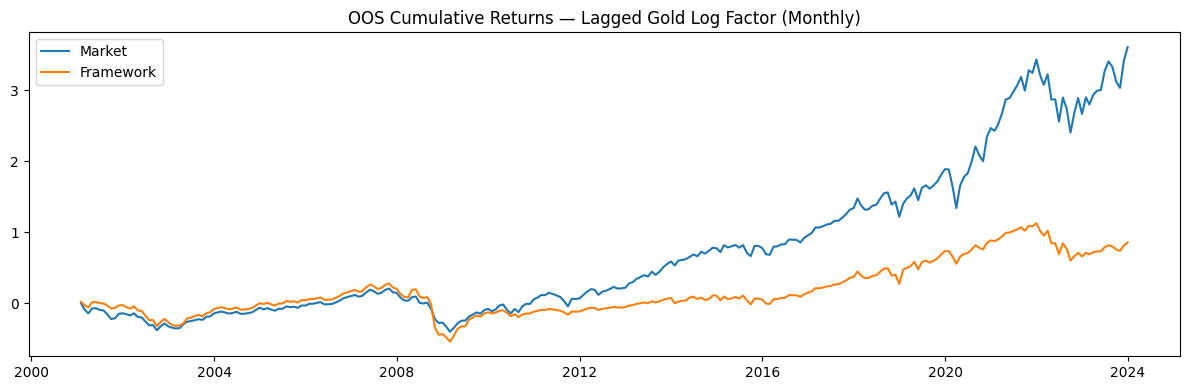

volstate_Gold Log Avg → Sharpe 0.84, MaxDD -9.7%



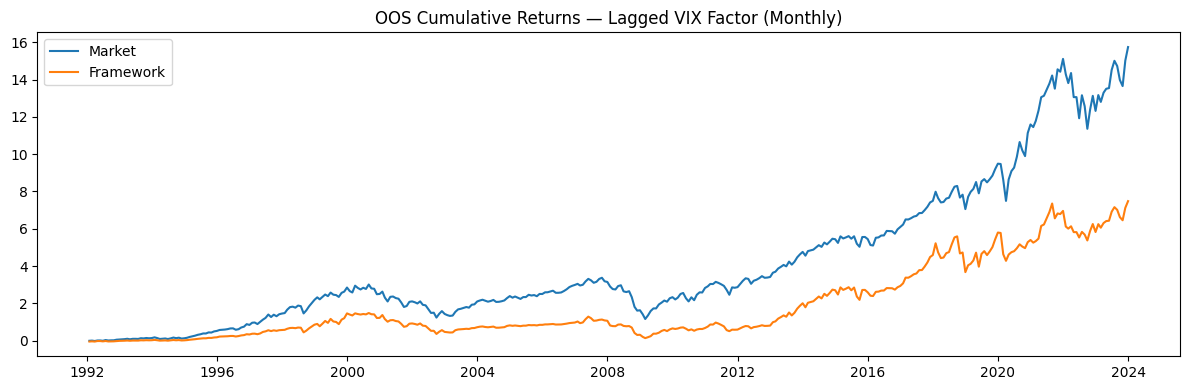

volstate_VIX Avg → Sharpe 0.96, MaxDD -10.1%

=== Performance Summary ===
                        Annual Return  Annual Volatility  Sharpe Ratio  \
Market                         0.0961             0.1472        0.5846   
volstate_Lag-1 S&P-500         0.0594             0.1641        0.3007   
volstate_Credit Spread         0.0847             0.1786        0.4180   
volstate_Gold Log              0.0453             0.1660        0.2126   
volstate_VIX                   0.0869             0.1745        0.4404   

                        Max Drawdown  
Market                        0.5048  
volstate_Lag-1 S&P-500        0.5115  
volstate_Credit Spread        0.6152  
volstate_Gold Log             0.6411  
volstate_VIX                  0.5019  


In [3241]:
import warnings
warnings.filterwarnings("ignore", message="Model is not converging")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from hmmlearn.hmm import GaussianHMM
import ruptures as rpt   # 用于结构性破裂检测



# ------------------------------------------------------------------
# 2 | Utility functions
# ------------------------------------------------------------------
def sharpe_ratio(log_returns, freq=12, rf=0.01):
    total_log  = np.sum(log_returns)
    annual_log = total_log * (freq / len(log_returns))
    annual_rtn = np.exp(annual_log) - 1
    vol_annual = np.std(log_returns, ddof=0) * np.sqrt(freq)
    return (annual_rtn - rf) / vol_annual

def max_drawdown(equity: pd.Series):
    dd = equity / equity.cummax() - 1
    return dd.min()

# ------------------------------------------------------------------
# 3 | Feature combos & 30‑day lag
# ------------------------------------------------------------------
combos = {
    'volstate_Lag-1 S&P-500': ['VolState', 'MarketReturn'],
    'volstate_Credit Spread':   ['VolState', 'credit_spread'],
    'volstate_Gold Log':   ['VolState', 'Gold_Log_Returns'],
    'volstate_VIX':   ['VolState', 'VIX']
}

# apply a 1‑day lag to all combo features
lag = 1
lag_cols = set().union(*combos.values())
df_lag = df.copy()
df_lag[list(lag_cols)] = df_lag[list(lag_cols)].shift(lag)

# ------------------------------------------------------------------
# 4 | Rolling forecasts with expanding‑window training by year
# ------------------------------------------------------------------
strategy_oos = {name: [] for name in combos}
metrics      = {name: [] for name in combos}
state_oos    = {name: [] for name in combos}

for name, feats in combos.items():
    # prepare full sample where all feat values are present
    X_all = df_lag[feats].dropna()
    y_all = df.loc[X_all.index, 'MarketReturn']

    freq_history = []
    exposures    = None
    final_map    = None

    # expanding window: train on all data before each year, test on that year
    for yr in range(1992, 2025):
        train_idx = X_all.index[X_all.index.year < yr]
        test_idx  = X_all.index[X_all.index.year == yr]

        # skip if insufficient data
        if len(train_idx) < 3 or len(test_idx) == 0:
            continue

        X_tr, y_tr = X_all.loc[train_idx].values, y_all.loc[train_idx].values
        X_te, y_te = X_all.loc[test_idx].values,  y_all.loc[test_idx].values

        # standardize
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr)
        X_te_s = scaler.transform(X_te)

        # fit HMM
        model = GaussianHMM(n_components=3, covariance_type='diag',
                            n_iter=200, tol=1e-2, random_state=0)
        model.min_covar = 1e-3
        model.fit(X_tr_s)

        # track state frequencies for break detection
        states_tr = model.predict(X_tr_s)
        freq      = np.bincount(states_tr, minlength=3) / len(states_tr)
        freq_history.append(freq)

        retrain = False
        if len(freq_history) >= 10:
            bkps = rpt.Pelt(model="rbf") \
                      .fit(np.array(freq_history)[:,0].reshape(-1,1)) \
                      .predict(pen=1.0)
            retrain = (bkps and bkps[-1] == len(freq_history))

        # calibrate exposures when first or after break
        if exposures is None or retrain:
            stats = []
            for s in range(3):
                mask = (states_tr == s)
                if mask.sum() > 0:
                    r      = y_tr[mask]
                    mu     = r.mean()
                    mad    = np.abs(r - mu).mean()
                    vol    = r.std()
                    sharpe = mu/vol if vol>0 else np.nan
                else:
                    mu = mad = vol = sharpe = np.nan
                stats.append({'state':s,'mean':mu,'mad':mad,'vol':vol,'sharpe':sharpe})
            df_stats       = pd.DataFrame(stats).set_index('state')
            df_stats['score']= (df_stats['sharpe'] + df_stats['mean']/df_stats['mad'])/2
            order          = df_stats['score'].sort_values().index.tolist()
            bear, side, bull = order
            exposures      = np.array([0.5,1.0,2.0])[np.argsort(order)]
            final_map      = (bear, side, bull)

        # OOS 隐状态 & 策略收益
        states_te = model.predict(X_te_s)
        # append to the per‑combo list, using test_idx for the index
        state_oos[name].append(pd.Series(states_te, index=test_idx))
        
        strat_ret = exposures[states_te] * y_te
        strategy_oos[name].append(pd.Series(strat_ret, index=test_idx))

        # record metrics
        mse   = mean_squared_error(y_te, strat_ret)
        mae   = mean_absolute_error(y_te, strat_ret)
        rmse  = np.sqrt(mse)
        denom = np.clip(strat_ret**2, 1e-6, None)
        qlike = np.mean((y_te**2)/denom - np.log((y_te**2)/denom) - 1)
        log_strat = np.log1p(strat_ret)
        sr        = sharpe_ratio(log_strat)
        eq    = (1 + pd.Series(strat_ret, index=test_idx)).cumprod()
        mdd   = max_drawdown(eq)

        metrics[name].append({
            'year': yr, 'MSE': mse, 'MAE': mae,
            'RMSE': rmse, 'QLIKE': qlike, 'Sharpe': sr, 'MaxDD': mdd
        })

    # print mapping & state distribution
    bear, side, bull = final_map
    print(f"{name} → bear={bear}, side={side}, bull={bull}")
    all_states = pd.concat(state_oos[name])
    print("State counts:", all_states.value_counts().sort_index(), "\n")

# ------------------------------------------------------------------
# 5 | Aggregate & plot (unchanged)
# ------------------------------------------------------------------
market_eq  = np.exp(df['MarketReturn'].cumsum())

for name in combos:
    strat = pd.concat(strategy_oos[name]).sort_index()
    
    # 原始的“累积净值”序列
    cum = (1 + strat).cumprod()
    
    # 把基点 1 → 0，得到“累积收益率”
    cum_return = cum - 1

    # 对齐 Market：先算 equity，再减 1
    mkt_eq    = market_eq.loc[cum_return.index.min():]
    mkt_return = mkt_eq / mkt_eq.iloc[0] - 1

    plt.figure(figsize=(12,4))
    plt.plot(mkt_return,    label='Market')
    plt.plot(cum_return,    label='Framework')
    
    # ←—— 这里改成动态 title
    factor = name.split('_', 1)[1]      # 'volstate_vix' → 'Vix'
    plt.title(f"OOS Cumulative Returns — Lagged {factor} Factor (Monthly)")
    
    plt.legend(); plt.tight_layout(); plt.show()

    dfm = pd.DataFrame(metrics[name]).set_index('year')
    avg = dfm.mean().to_dict()
    
    # 用同样的逻辑打印表格
    print(f"{name} Avg → Sharpe {avg['Sharpe']:.2f}, MaxDD {avg['MaxDD']*100:.1f}%\n")

import matplotlib.gridspec as gridspec

# ——— 5.1 annual_return 函数 ———
def annual_return(log_returns, freq=252):
    tot = np.sum(log_returns)
    return np.exp(tot * (freq / len(log_returns))) - 1

# ——— 5.2 收集 Market & 各策略的 log‑returns ———
log_rets = {'Market': df['MarketReturn']}
for name in combos:
    strat = pd.concat(strategy_oos[name]).sort_index()
    log_rets[name] = np.log1p(strat)

# 对齐起始点
start = max(series.index.min() for series in log_rets.values())

# ——— 5.3 计算绩效指标 ———
perf = {}
freq = 12  # 日度：252；月度改成 12
for name, logs in log_rets.items():
    logs = logs.loc[start:]
    ann_ret = annual_return(logs, freq)
    ann_vol = np.std(logs, ddof=0) * np.sqrt(freq)
    sharpe  = sharpe_ratio(logs, freq=freq)
    eq      = np.exp(logs.cumsum())
    mdd     = max_drawdown(eq)
    perf[name] = [ann_ret, ann_vol, sharpe, abs(mdd)]

# 转 pandas DataFrame 并打印
df_perf = pd.DataFrame.from_dict(
    perf, orient='index',
    columns=['Annual Return','Annual Volatility','Sharpe Ratio','Max Drawdown']
).round(4)

print("=== Performance Summary ===")
print(df_perf)

Model is not converging.  Current: 6.860787463581083 is not greater than 7.789200471405329. Delta is -0.9284130078242461
Model is not converging.  Current: 6.806237013803313 is not greater than 9.301011347796992. Delta is -2.4947743339936794
Model is not converging.  Current: 157.4794957260984 is not greater than 157.53314615670078. Delta is -0.0536504306023744


volstate_Yield Spread → bear=1, side=0, bull=2
State counts: 0    348
1      8
2     28
Name: count, dtype: int64 

volstate_PMI → bear=1, side=2, bull=0
State counts: 0    319
1     28
2     37
Name: count, dtype: int64 



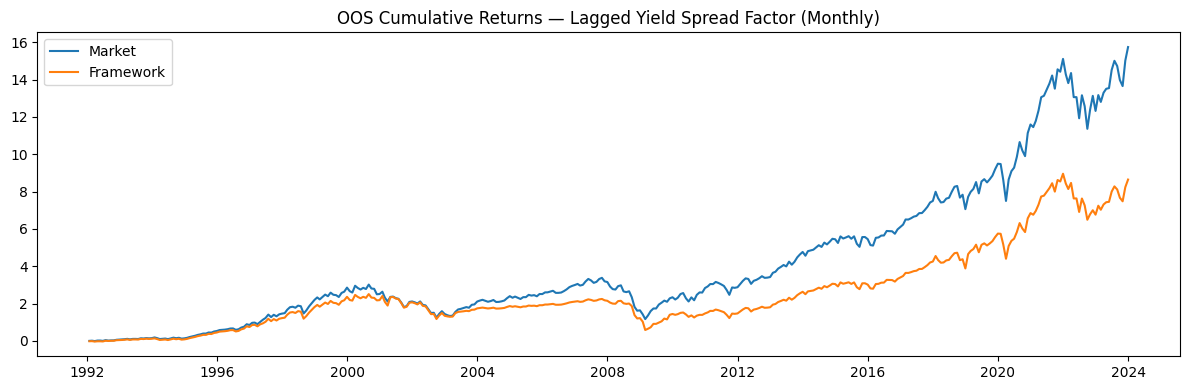

volstate_Yield Spread Avg → Sharpe 1.05, MaxDD -9.1%



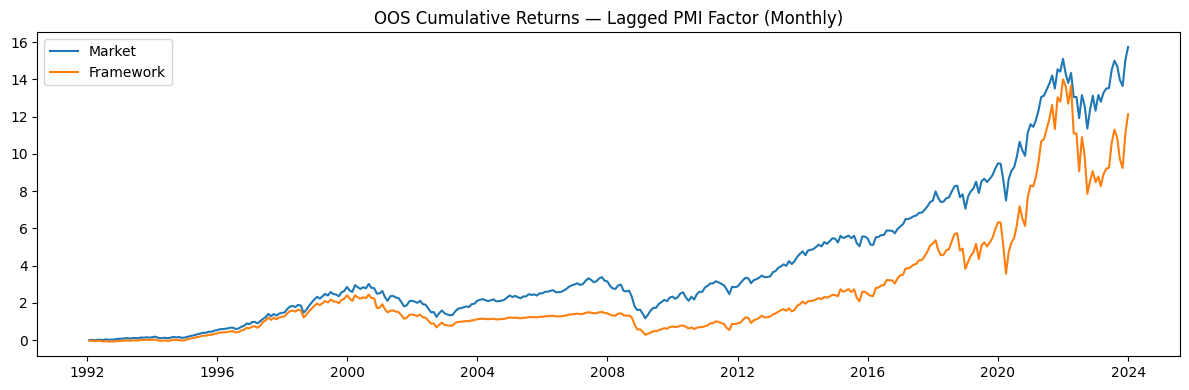

volstate_PMI Avg → Sharpe 1.01, MaxDD -12.6%

=== Performance Summary ===
                       Annual Return  Annual Volatility  Sharpe Ratio  \
Market                        0.0914             0.1477        0.5509   
volstate_Yield Spread         0.0734             0.1494        0.4243   
volstate_PMI                  0.0838             0.2061        0.3581   

                       Max Drawdown  
Market                       0.5048  
volstate_Yield Spread        0.5488  
volstate_PMI                 0.6274  


In [3239]:
import warnings
warnings.filterwarnings("ignore", message="Model is not converging")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from hmmlearn.hmm import GaussianHMM
import ruptures as rpt   # 用于结构性破裂检测

# ------------------------------------------------------------------
# 2 | Utility functions
# ------------------------------------------------------------------
def sharpe_ratio(log_returns, freq=12, rf=0.01):
    total_log  = np.sum(log_returns)
    annual_log = total_log * (freq / len(log_returns))
    annual_rtn = np.exp(annual_log) - 1
    vol_annual = np.std(log_returns, ddof=0) * np.sqrt(freq)
    return (annual_rtn - rf) / vol_annual

def max_drawdown(equity: pd.Series):
    dd = equity / equity.cummax() - 1
    return dd.min()

# ------------------------------------------------------------------
# 3 | Feature combos & 30‑day lag
# ------------------------------------------------------------------
combos = {
    'volstate_Yield Spread': ['VolState', 'treasury_difference_10_2'],
    'volstate_PMI':   ['VolState', 'PMI']

}

# apply a 30‑day lag to all combo features
lag = 1
lag_cols = set().union(*combos.values())
df_lag = df.copy()
df_lag[list(lag_cols)] = df_lag[list(lag_cols)].shift(lag)

# ------------------------------------------------------------------
# 4 | Rolling forecasts with expanding‑window training by year
# ------------------------------------------------------------------
strategy_oos = {name: [] for name in combos}
metrics      = {name: [] for name in combos}
state_oos    = {name: [] for name in combos}

for name, feats in combos.items():
    # prepare full sample where all feat values are present
    X_all = df_lag[feats].dropna()
    y_all = df.loc[X_all.index, 'MarketReturn']

    freq_history = []
    exposures    = None
    final_map    = None

    # expanding window: train on all data before each year, test on that year
    for yr in range(1992, 2025):
        train_idx = X_all.index[X_all.index.year < yr]
        test_idx  = X_all.index[X_all.index.year == yr]

        # skip if insufficient data
        if len(train_idx) < 3 or len(test_idx) == 0:
            continue

        X_tr, y_tr = X_all.loc[train_idx].values, y_all.loc[train_idx].values
        X_te, y_te = X_all.loc[test_idx].values,  y_all.loc[test_idx].values

        # standardize
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr)
        X_te_s = scaler.transform(X_te)

        # fit HMM
        model = GaussianHMM(n_components=3, covariance_type='diag',
                            n_iter=200, tol=1e-2, random_state=0)
        model.min_covar = 1e-3
        model.fit(X_tr_s)

        # track state frequencies for break detection
        states_tr = model.predict(X_tr_s)
        freq      = np.bincount(states_tr, minlength=3) / len(states_tr)
        freq_history.append(freq)

        retrain = False
        if len(freq_history) >= 10:
            bkps = rpt.Pelt(model="rbf") \
                      .fit(np.array(freq_history)[:,0].reshape(-1,1)) \
                      .predict(pen=1.0)
            retrain = (bkps and bkps[-1] == len(freq_history))

        # calibrate exposures when first or after break
        if exposures is None or retrain:
            stats = []
            for s in range(3):
                mask = (states_tr == s)
                if mask.sum() > 0:
                    r      = y_tr[mask]
                    mu     = r.mean()
                    mad    = np.abs(r - mu).mean()
                    vol    = r.std()
                    sharpe = mu/vol if vol>0 else np.nan
                else:
                    mu = mad = vol = sharpe = np.nan
                stats.append({'state':s,'mean':mu,'mad':mad,'vol':vol,'sharpe':sharpe})
            df_stats       = pd.DataFrame(stats).set_index('state')
            df_stats['score']= (df_stats['sharpe'] + df_stats['mean']/df_stats['mad'])/2
            order          = df_stats['score'].sort_values().index.tolist()
            bear, side, bull = order
            exposures      = np.array([0.5,1.0,2.0])[np.argsort(order)]
            final_map      = (bear, side, bull)

        # OOS 隐状态 & 策略收益
        states_te = model.predict(X_te_s)
        # append to the per‑combo list, using test_idx for the index
        state_oos[name].append(pd.Series(states_te, index=test_idx))
        
        strat_ret = exposures[states_te] * y_te
        strategy_oos[name].append(pd.Series(strat_ret, index=test_idx))

        # record metrics
        mse   = mean_squared_error(y_te, strat_ret)
        mae   = mean_absolute_error(y_te, strat_ret)
        rmse  = np.sqrt(mse)
        denom = np.clip(strat_ret**2, 1e-6, None)
        qlike = np.mean((y_te**2)/denom - np.log((y_te**2)/denom) - 1)
        log_strat = np.log1p(strat_ret)
        sr        = sharpe_ratio(log_strat)
        eq    = (1 + pd.Series(strat_ret, index=test_idx)).cumprod()
        mdd   = max_drawdown(eq)

        metrics[name].append({
            'year': yr, 'MSE': mse, 'MAE': mae,
            'RMSE': rmse, 'QLIKE': qlike, 'Sharpe': sr, 'MaxDD': mdd
        })

    # print mapping & state distribution
    bear, side, bull = final_map
    print(f"{name} → bear={bear}, side={side}, bull={bull}")
    all_states = pd.concat(state_oos[name])
    print("State counts:", all_states.value_counts().sort_index(), "\n")

# ------------------------------------------------------------------
# 5 | Aggregate & plot (unchanged)
# ------------------------------------------------------------------
market_eq  = np.exp(df['MarketReturn'].cumsum())

for name in combos:
    strat = pd.concat(strategy_oos[name]).sort_index()
    
    # 原始的“累积净值”序列
    cum = (1 + strat).cumprod()
    
    # 把基点 1 → 0，得到“累积收益率”
    cum_return = cum - 1

    # 对齐 Market：先算 equity，再减 1
    mkt_eq    = market_eq.loc[cum_return.index.min():]
    mkt_return = mkt_eq / mkt_eq.iloc[0] - 1

    plt.figure(figsize=(12,4))
    plt.plot(mkt_return,    label='Market')
    plt.plot(cum_return,    label='Framework')
    
    # ←—— 这里改成动态 title
    factor = name.split('_', 1)[1]      # 'volstate_vix' → 'Vix'
    plt.title(f"OOS Cumulative Returns — Lagged {factor} Factor (Monthly)")
    
    plt.legend(); plt.tight_layout(); plt.show()

    dfm = pd.DataFrame(metrics[name]).set_index('year')
    avg = dfm.mean().to_dict()
    
    # 用同样的逻辑打印表格
    print(f"{name} Avg → Sharpe {avg['Sharpe']:.2f}, MaxDD {avg['MaxDD']*100:.1f}%\n")

import matplotlib.gridspec as gridspec

# ——— 5.1 annual_return 函数 ———
def annual_return(log_returns, freq=252):
    tot = np.sum(log_returns)
    return np.exp(tot * (freq / len(log_returns))) - 1

# ——— 5.2 收集 Market & 各策略的 log‑returns ———
log_rets = {'Market': df['MarketReturn']}
for name in combos:
    strat = pd.concat(strategy_oos[name]).sort_index()
    log_rets[name] = np.log1p(strat)

# 对齐起始点
start = max(series.index.min() for series in log_rets.values())

# ——— 5.3 计算绩效指标 ———
perf = {}
freq = 12  # 日度：252；月度改成 12
for name, logs in log_rets.items():
    logs = logs.loc[start:]
    ann_ret = annual_return(logs, freq)
    ann_vol = np.std(logs, ddof=0) * np.sqrt(freq)
    sharpe  = sharpe_ratio(logs, freq=freq)
    eq      = np.exp(logs.cumsum())
    mdd     = max_drawdown(eq)
    perf[name] = [ann_ret, ann_vol, sharpe, abs(mdd)]

# 转 pandas DataFrame 并打印
df_perf = pd.DataFrame.from_dict(
    perf, orient='index',
    columns=['Annual Return','Annual Volatility','Sharpe Ratio','Max Drawdown']
).round(4)

print("=== Performance Summary ===")
print(df_perf)
# 如果你想要 LaTeX 格式，你可以：
# print(df_perf.to_latex())


Model is not converging.  Current: 6370.136651800288 is not greater than 6370.13665318942. Delta is -1.389132194162812e-06


volstate_Sentiment → bear=0, side=2, bull=1
State counts: 0    6353
1     739
2     713
Name: count, dtype: int64 



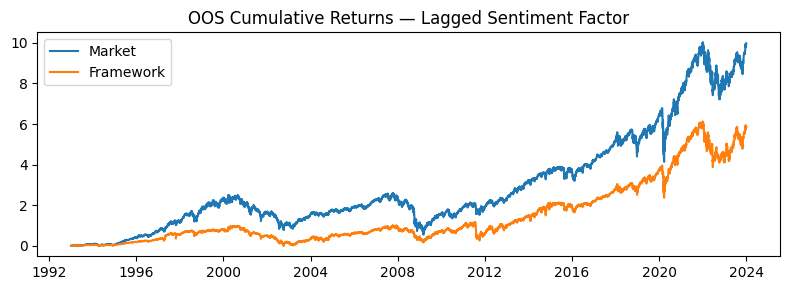

volstate_Sentiment Avg → Sharpe -0.23, MaxDD -14.7%

=== Performance Summary ===
                    Annual Return  Annual Volatility  Sharpe Ratio  \
Market                     0.0037             0.0405       -0.1557   
volstate_Sentiment         0.0030             0.0404       -0.1744   

                    Max Drawdown  
Market                    0.5678  
volstate_Sentiment        0.4944  


In [3070]:
import warnings
warnings.filterwarnings("ignore", message="Model is not converging")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from hmmlearn.hmm import GaussianHMM
import ruptures as rpt   # 用于结构性破裂检测



# ------------------------------------------------------------------
# 2 | Utility functions
# ------------------------------------------------------------------
def sharpe_ratio(log_returns, freq=12, rf=0.01):
    total_log  = np.sum(log_returns)
    annual_log = total_log * (freq / len(log_returns))
    annual_rtn = np.exp(annual_log) - 1
    vol_annual = np.std(log_returns, ddof=0) * np.sqrt(freq)
    return (annual_rtn - rf) / vol_annual

def max_drawdown(equity: pd.Series):
    dd = equity / equity.cummax() - 1
    return dd.min()

# ------------------------------------------------------------------
# 3 | Feature combos & 30‑day lag
# ------------------------------------------------------------------
combos = {
    'volstate_Sentiment': ['VolState', 'sentiment_score']
}

# apply a 90‑day lag to all combo features
lag = 3
lag_cols = set().union(*combos.values())
df_lag = df.copy()
df_lag[list(lag_cols)] = df_lag[list(lag_cols)].shift(lag)

# ------------------------------------------------------------------
# 4 | Rolling forecasts with expanding‑window training by year
# ------------------------------------------------------------------
strategy_oos = {name: [] for name in combos}
metrics      = {name: [] for name in combos}
state_oos    = {name: [] for name in combos}

for name, feats in combos.items():
    # prepare full sample where all feat values are present
    X_all = df_lag[feats].dropna()
    y_all = df.loc[X_all.index, 'MarketReturn']

    freq_history = []
    exposures    = None
    final_map    = None

    # expanding window: train on all data before each year, test on that year
    for yr in range(1992, 2025):
        train_idx = X_all.index[X_all.index.year < yr]
        test_idx  = X_all.index[X_all.index.year == yr]

        # skip if insufficient data
        if len(train_idx) < 3 or len(test_idx) == 0:
            continue

        X_tr, y_tr = X_all.loc[train_idx].values, y_all.loc[train_idx].values
        X_te, y_te = X_all.loc[test_idx].values,  y_all.loc[test_idx].values

        # standardize
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr)
        X_te_s = scaler.transform(X_te)

        # fit HMM
        model = GaussianHMM(n_components=3, covariance_type='diag',
                            n_iter=200, tol=1e-2, random_state=0)
        model.min_covar = 1e-3
        model.fit(X_tr_s)

        # track state frequencies for break detection
        states_tr = model.predict(X_tr_s)
        freq      = np.bincount(states_tr, minlength=3) / len(states_tr)
        freq_history.append(freq)

        retrain = False
        if len(freq_history) >= 10:
            bkps = rpt.Pelt(model="rbf") \
                      .fit(np.array(freq_history)[:,0].reshape(-1,1)) \
                      .predict(pen=1.0)
            retrain = (bkps and bkps[-1] == len(freq_history))

        # calibrate exposures when first or after break
        if exposures is None or retrain:
            stats = []
            for s in range(3):
                mask = (states_tr == s)
                if mask.sum() > 0:
                    r      = y_tr[mask]
                    mu     = r.mean()
                    mad    = np.abs(r - mu).mean()
                    vol    = r.std()
                    sharpe = mu/vol if vol>0 else np.nan
                else:
                    mu = mad = vol = sharpe = np.nan
                stats.append({'state':s,'mean':mu,'mad':mad,'vol':vol,'sharpe':sharpe})
            df_stats       = pd.DataFrame(stats).set_index('state')
            df_stats['score']= (df_stats['sharpe'] + df_stats['mean']/df_stats['mad'])/2
            order          = df_stats['score'].sort_values().index.tolist()
            bear, side, bull = order
            exposures      = np.array([0.5,1.0,2.0])[np.argsort(order)]
            final_map      = (bear, side, bull)

        # OOS 隐状态 & 策略收益
        states_te = model.predict(X_te_s)
        # append to the per‑combo list, using test_idx for the index
        state_oos[name].append(pd.Series(states_te, index=test_idx))
        
        strat_ret = exposures[states_te] * y_te
        strategy_oos[name].append(pd.Series(strat_ret, index=test_idx))

        # record metrics
        mse   = mean_squared_error(y_te, strat_ret)
        mae   = mean_absolute_error(y_te, strat_ret)
        rmse  = np.sqrt(mse)
        denom = np.clip(strat_ret**2, 1e-6, None)
        qlike = np.mean((y_te**2)/denom - np.log((y_te**2)/denom) - 1)
        log_strat = np.log1p(strat_ret)
        sr        = sharpe_ratio(log_strat)
        eq    = (1 + pd.Series(strat_ret, index=test_idx)).cumprod()
        mdd   = max_drawdown(eq)

        metrics[name].append({
            'year': yr, 'MSE': mse, 'MAE': mae,
            'RMSE': rmse, 'QLIKE': qlike, 'Sharpe': sr, 'MaxDD': mdd
        })

    # print mapping & state distribution
    bear, side, bull = final_map
    print(f"{name} → bear={bear}, side={side}, bull={bull}")
    all_states = pd.concat(state_oos[name])
    print("State counts:", all_states.value_counts().sort_index(), "\n")


# ------------------------------------------------------------------
# 5 | Aggregate & plot (unchanged)
# ------------------------------------------------------------------
for name in combos:
    strat = pd.concat(strategy_oos[name]).sort_index()
    
    # 原始的“累积净值”序列
    cum = (1 + strat).cumprod()
    
    # 把基点 1 → 0，得到“累积收益率”
    cum_return = cum - 1

    # 对齐 Market：先算 equity，再减 1
    mkt_eq    = market_eq.loc[cum_return.index.min():]
    mkt_return = mkt_eq / mkt_eq.iloc[0] - 1

    plt.figure(figsize=(12,4))
    plt.plot(mkt_return,    label='Market')
    plt.plot(cum_return,    label='Framework')
    # ←—— 这里改成动态 title
    factor = name.split('_', 1)[1]      # 'volstate_vix' → 'Vix'
    plt.title(f"OOS Cumulative Returns — Lagged {factor} Factor")
    
    plt.legend(); plt.tight_layout(); plt.show()

    dfm = pd.DataFrame(metrics[name]).set_index('year')
    avg = dfm.mean().to_dict()
    
    # 用同样的逻辑打印表格
    print(f"{name} Avg → Sharpe {avg['Sharpe']:.2f}, MaxDD {avg['MaxDD']*100:.1f}%\n")

import matplotlib.gridspec as gridspec

# ——— 5.1 annual_return 函数 ———
def annual_return(log_returns, freq=252):
    tot = np.sum(log_returns)
    return np.exp(tot * (freq / len(log_returns))) - 1

# ——— 5.2 收集 Market & 各策略的 log‑returns ———
log_rets = {'Market': df['MarketReturn']}
for name in combos:
    strat = pd.concat(strategy_oos[name]).sort_index()
    log_rets[name] = np.log1p(strat)

# 对齐起始点
start = max(series.index.min() for series in log_rets.values())

# ——— 5.3 计算绩效指标 ———
perf = {}
freq = 12  # 日度：252；月度改成 12
for name, logs in log_rets.items():
    logs = logs.loc[start:]
    ann_ret = annual_return(logs, freq)
    ann_vol = np.std(logs, ddof=0) * np.sqrt(freq)
    sharpe  = sharpe_ratio(logs, freq=freq)
    eq      = np.exp(logs.cumsum())
    mdd     = max_drawdown(eq)
    perf[name] = [ann_ret, ann_vol, sharpe, abs(mdd)]

# 转 pandas DataFrame 并打印
df_perf = pd.DataFrame.from_dict(
    perf, orient='index',
    columns=['Annual Return','Annual Volatility','Sharpe Ratio','Max Drawdown']
).round(4)

print("=== Performance Summary ===")
print(df_perf)

volstate_GDP → bear=1, side=0, bull=2
State counts: 0    7047
1     715
2     297
Name: count, dtype: int64 



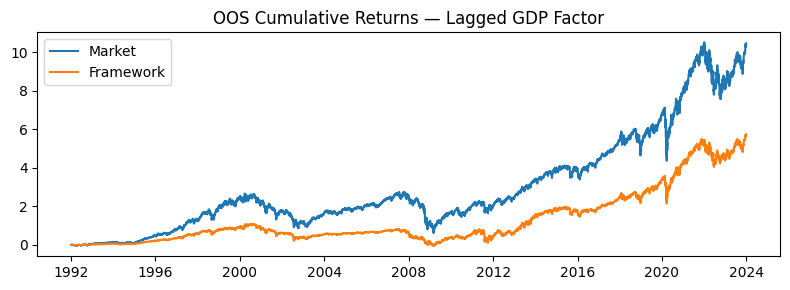

volstate_GDP Avg → Sharpe -0.32, MaxDD -12.5%

=== Performance Summary ===
              Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown
Market               0.0036             0.0401       -0.1588        0.5678
volstate_GDP         0.0028             0.0373       -0.1921        0.5500


In [3072]:
import warnings
warnings.filterwarnings("ignore", message="Model is not converging")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from hmmlearn.hmm import GaussianHMM
import ruptures as rpt   # 用于结构性破裂检测


# ------------------------------------------------------------------
# 2 | Utility functions
# ------------------------------------------------------------------
def sharpe_ratio(log_returns, freq=12, rf=0.01):
    total_log  = np.sum(log_returns)
    annual_log = total_log * (freq / len(log_returns))
    annual_rtn = np.exp(annual_log) - 1
    vol_annual = np.std(log_returns, ddof=0) * np.sqrt(freq)
    return (annual_rtn - rf) / vol_annual

def max_drawdown(equity: pd.Series):
    dd = equity / equity.cummax() - 1
    return dd.min()

# ------------------------------------------------------------------
# 3 | Feature combos & 30‑day lag
# ------------------------------------------------------------------
combos = {
    'volstate_GDP': ['VolState', 'GDP']
}

# apply a 1‑day lag to all combo features
lag = 4
lag_cols = set().union(*combos.values())
df_lag = df.copy()
df_lag[list(lag_cols)] = df_lag[list(lag_cols)].shift(lag)

# ------------------------------------------------------------------
# 4 | Rolling forecasts with expanding‑window training by year
# ------------------------------------------------------------------
strategy_oos = {name: [] for name in combos}
metrics      = {name: [] for name in combos}
state_oos    = {name: [] for name in combos}

for name, feats in combos.items():
    # prepare full sample where all feat values are present
    X_all = df_lag[feats].dropna()
    y_all = df.loc[X_all.index, 'MarketReturn']

    freq_history = []
    exposures    = None
    final_map    = None

    # expanding window: train on all data before each year, test on that year
    for yr in range(1992, 2025):
        train_idx = X_all.index[X_all.index.year < yr]
        test_idx  = X_all.index[X_all.index.year == yr]

        # skip if insufficient data
        if len(train_idx) < 3 or len(test_idx) == 0:
            continue

        X_tr, y_tr = X_all.loc[train_idx].values, y_all.loc[train_idx].values
        X_te, y_te = X_all.loc[test_idx].values,  y_all.loc[test_idx].values

        # standardize
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr)
        X_te_s = scaler.transform(X_te)

        # fit HMM
        model = GaussianHMM(n_components=3, covariance_type='diag',
                            n_iter=200, tol=1e-2, random_state=0)
        model.min_covar = 1e-3
        model.fit(X_tr_s)

        # track state frequencies for break detection
        states_tr = model.predict(X_tr_s)
        freq      = np.bincount(states_tr, minlength=3) / len(states_tr)
        freq_history.append(freq)

        retrain = False
        if len(freq_history) >= 10:
            bkps = rpt.Pelt(model="rbf") \
                      .fit(np.array(freq_history)[:,0].reshape(-1,1)) \
                      .predict(pen=1.0)
            retrain = (bkps and bkps[-1] == len(freq_history))

        # calibrate exposures when first or after break
        if exposures is None or retrain:
            stats = []
            for s in range(3):
                mask = (states_tr == s)
                if mask.sum() > 0:
                    r      = y_tr[mask]
                    mu     = r.mean()
                    mad    = np.abs(r - mu).mean()
                    vol    = r.std()
                    sharpe = mu/vol if vol>0 else np.nan
                else:
                    mu = mad = vol = sharpe = np.nan
                stats.append({'state':s,'mean':mu,'mad':mad,'vol':vol,'sharpe':sharpe})
            df_stats       = pd.DataFrame(stats).set_index('state')
            df_stats['score']= (df_stats['sharpe'] + df_stats['mean']/df_stats['mad'])/2
            order          = df_stats['score'].sort_values().index.tolist()
            bear, side, bull = order
            exposures      = np.array([0.5,1.0,2.0])[np.argsort(order)]
            final_map      = (bear, side, bull)

        # OOS 隐状态 & 策略收益
        states_te = model.predict(X_te_s)
        # append to the per‑combo list, using test_idx for the index
        state_oos[name].append(pd.Series(states_te, index=test_idx))
        
        strat_ret = exposures[states_te] * y_te
        strategy_oos[name].append(pd.Series(strat_ret, index=test_idx))

        # record metrics
        mse   = mean_squared_error(y_te, strat_ret)
        mae   = mean_absolute_error(y_te, strat_ret)
        rmse  = np.sqrt(mse)
        denom = np.clip(strat_ret**2, 1e-6, None)
        qlike = np.mean((y_te**2)/denom - np.log((y_te**2)/denom) - 1)
        log_strat = np.log1p(strat_ret)
        sr        = sharpe_ratio(log_strat)
        eq    = (1 + pd.Series(strat_ret, index=test_idx)).cumprod()
        mdd   = max_drawdown(eq)

        metrics[name].append({
            'year': yr, 'MSE': mse, 'MAE': mae,
            'RMSE': rmse, 'QLIKE': qlike, 'Sharpe': sr, 'MaxDD': mdd
        })

    # print mapping & state distribution
    bear, side, bull = final_map
    print(f"{name} → bear={bear}, side={side}, bull={bull}")
    all_states = pd.concat(state_oos[name])
    print("State counts:", all_states.value_counts().sort_index(), "\n")

# ------------------------------------------------------------------
# 5 | Aggregate & plot (unchanged)
# ------------------------------------------------------------------
market_eq  = np.exp(df['MarketReturn'].cumsum())

for name in combos:
    strat = pd.concat(strategy_oos[name]).sort_index()
    
    # 原始的“累积净值”序列
    cum = (1 + strat).cumprod()
    
    # 把基点 1 → 0，得到“累积收益率”
    cum_return = cum - 1

    # 对齐 Market：先算 equity，再减 1
    mkt_eq    = market_eq.loc[cum_return.index.min():]
    mkt_return = mkt_eq / mkt_eq.iloc[0] - 1

    plt.figure(figsize=(12,4))
    plt.plot(mkt_return,    label='Market')
    plt.plot(cum_return,    label='Framework')

    
    # ←—— 这里改成动态 title
    factor = name.split('_', 1)[1]      # 'volstate_vix' → 'Vix'
    plt.title(f"OOS Cumulative Returns — Lagged {factor} Factor")
    
    plt.legend(); plt.tight_layout(); plt.show()

    dfm = pd.DataFrame(metrics[name]).set_index('year')
    avg = dfm.mean().to_dict()
    
    # 用同样的逻辑打印表格
    print(f"{name} Avg → Sharpe {avg['Sharpe']:.2f}, MaxDD {avg['MaxDD']*100:.1f}%\n")

import matplotlib.gridspec as gridspec

# ——— 5.1 annual_return 函数 ———
def annual_return(log_returns, freq=252):
    tot = np.sum(log_returns)
    return np.exp(tot * (freq / len(log_returns))) - 1

# ——— 5.2 收集 Market & 各策略的 log‑returns ———
log_rets = {'Market': df['MarketReturn']}
for name in combos:
    strat = pd.concat(strategy_oos[name]).sort_index()
    log_rets[name] = np.log1p(strat)

# 对齐起始点
start = max(series.index.min() for series in log_rets.values())

# ——— 5.3 计算绩效指标 ———
perf = {}
freq = 12  # 日度：252；月度改成 12
for name, logs in log_rets.items():
    logs = logs.loc[start:]
    ann_ret = annual_return(logs, freq)
    ann_vol = np.std(logs, ddof=0) * np.sqrt(freq)
    sharpe  = sharpe_ratio(logs, freq=freq)
    eq      = np.exp(logs.cumsum())
    mdd     = max_drawdown(eq)
    perf[name] = [ann_ret, ann_vol, sharpe, abs(mdd)]

# 转 pandas DataFrame 并打印
df_perf = pd.DataFrame.from_dict(
    perf, orient='index',
    columns=['Annual Return','Annual Volatility','Sharpe Ratio','Max Drawdown']
).round(4)

print("=== Performance Summary ===")
print(df_perf)